**RESEARCH QUESTIONS**

1. What subjects are most commonly depicted in artworks during the Italian Renaissance?

2. How does the iconography evolve over time?

3. In which geographical locations are certain objects/subjects more likely to be depicted?

---

### This notebook goes through a basic exploratory data analysis of the **Iconology Dataset** and **Zeri Photo Archive RDF Dataset** using Python.

I will perform different kinds of exploratory data analysis to gain an exhaustive understanding of the data represented in the two original datasets.

The various phases of the EDA will be:
1. Acquire and parse
2. Filter and mine
3. Represent
4. Refine
5. Interact

# 0. Why EDA?

**Data**, in their raw form, gain meaning through relational connections, transforming into **information**. Information answers questions starting with interrogative words like *who, what, when, where,* and *how many*. However, information truly becomes valuable when it evolves into **knowledge**. Knowledge represents a purposeful collection of information, intended for utility. As knowledge accumulates, it enables reflection, potentially leading to **wisdom**.

To achieve this progression, understanding serves as a continuum that begins with data, transitions through information and knowledge, and culminates in wisdom. This concept is encapsulated in the ***"DIKW Pyramid"*** (Ackoff, 1989), where data forms the foundational layer, leading to wisdom, the ultimate tier.

Data represent abstractions of concepts and real-world entities (such as people, paintings, or places) with their associated attributes or features, forming classes of objects. These data are then collated and stored in datasets, often represented in tabular format, where rows denote entities and columns represent their attributes.

Given the variability in such abstractions, **Exploratory Data Analysis (EDA)** becomes crucial in unraveling these structures. EDA aids in uncovering insights about the data, deciphering their representations and implications.

This is an iterative process since datasets consistently unveil features that might have been initially overlooked.

Let's embark on this journey!

# 1. Acquire and Parse

For this project, two primary sources of data will be utilized: the ***[Iconology Dataset](https://iconology-dataset.streamlit.app/)*** and the ***[Zeri Photo Archive RDF dataset](https://data.fondazionezeri.unibo.it/)***.

## Iconology Dataset
The first RDF dataset originated as part of a PhD project in Digital Humanities at the University of Bologna, led by *Sofia Baroncini*. It presents structured content comprising interpretations by art historian Erwin Panofsky and other esteemed art historians. The dataset is currently published under the CC-BY-SA 4.0 license and is accessible at ***[https://w3id.org/icon/data/](https://w3id.org/icon/data/)***.

## Zeri Photo Archive Collection
The second dataset, the Zeri Photo Archive RDF, is a substantial subset of the data available at the Zeri Catalog website and discoverable through the Europeana Portal. The Federico Zeri Foundation was established in 1999 by the University of Bologna with the intention of honoring Federico Zeri's life, preserving his legacy, and maximizing its potential. It encompasses an Art Library consisting of 46,000 volumes, 37,000 auction catalogs, and 60 periodicals, alongside a Photo Archive containing 290,000 photographs of monuments and artworks. The SPARQL endpoint is currently under maintenance ([http://data.fondazionezeri.unibo.it/sparql](http://data.fondazionezeri.unibo.it/sparql)), thus the data utilized will be sourced from ***[https://amsacta.unibo.it/id/eprint/5497/](https://amsacta.unibo.it/id/eprint/5497/)***.


### Installations and Imports

The following script installs and imports the necessary libraries utilized in this documentation. Uncomment the packages that you require for the imports.

In [1]:
# Install the packages needed in the Notebook

#!pip install rdflib
#!pip install SPARQLWrapper
#!pip install pandas
#!pip install sparql-dataframe
#!pip install prettyprinter
#!pip install matplotlib
#!pip install seaborn
#!pip install bokeh
#!pip install ipyleaflet #this package nee also to be registered with: jupyter nbextension enable --py --sys-prefix ipyleaflet
#!pip install folium
#!pip install nltk

In [9]:
# Import necessary libraries

# RDFlib
from rdflib import Graph, URIRef, Namespace
from rdflib.plugins.sparql import prepareQuery
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL, \
                           PROF, PROV, RDF, RDFS, SDO, SH, SKOS, SOSA, SSN, TIME, \
                           VOID, XMLNS, XSD, NamespaceManager

# SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON

# pandas
import pandas as pd

# sparql_dataframe
import sparql_dataframe

# prettyprinter
from prettyprinter import pprint

# matplotlib
import matplotlib.pyplot as plt

# seaborn
import seaborn as sns

# datatime
from datetime import datetime

# json
import json

# datatime
from datetime import datetime

# os
import os

# regular expressions
import re

# bokeh
#from bokeh.io import output_notebook
#from bokeh.plotting import figure
#output_notebook()

# ipyleaflet
from ipyleaflet import Map, basemaps, Marker, MarkerCluster

# folium
import folium
from folium.plugins import MarkerCluster

# nltk
import nltk
from nltk.corpus import stopwords
# Download NLTK stopwords (run this line the first time)
#nltk.download('stopwords')

## 1.1. Parse Iconology Dataset
Firstly, we parsed the Iconology RDF data into a graph to enable SPARQL queries for exploring the content.

In [2]:
# Initialize an RDF graph
iconology_graph = Graph()

# Define the endpoint URL
endpoint_url = 'https://w3id.org/icon/data/'

# Load the RDF data from the endpoint into the graph, specifying the format
try:
    iconology_graph.parse(endpoint_url, format='turtle')
    print("RDF data successfully loaded from the endpoint.")
except Exception as e:
    print("Failed to load RDF data from the endpoint:", e)

RDF data successfully loaded from the endpoint.


## 1.2. Parse Zeri Photo Archive Collection

Next, we proceed to parse the Zeri Photo Archive RDF downloaded from the provided link.
Ensure that you replace `directory` in the script with the actual directory path where the folder containing the downloaded data is located.

In [3]:
# Dataset local path
directory = '/Users/stefano_renzetti/Library/CloudStorage/Dropbox/DHDK/INFORMATION VISUALIZATION/_sources/FONDAZIONE-ZERI-RDF/dump-complete'

# Initialize an RDF graph
zeri_graph = Graph()

try:
    # Iterate through files in the directory, parse each file into a separate graph
    for filename in os.listdir(directory):
        if filename.endswith('.rdf'):  # Adjust the file extension if needed
            file_path = os.path.join(directory, filename)
            zeri_graph.parse(file_path, format='xml', strict=False)  # Allow parsing with invalid URIs

    print("RDF data successfully loaded from the directory.")

    # Determine the number of triples in the graph
    number_of_triples = len(zeri_graph)
    
    print(f"The graph contains {number_of_triples} triples.")

except Exception as e:
    print("Failed to load RDF data from the directory:", e)

https://w3id.org/zericatalog/criterion/Author's choice does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Title printed on recto of photograph does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Author's choice does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Title printed on recto of photograph does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Author's choice does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Title printed on recto of photograph does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Author's choice does not look like a valid URI, trying to serialize this will break.
https://w3id.org/zericatalog/criterion/Title printed on recto of phot

RDF data successfully loaded from the directory.
The graph contains 11992953 triples.


The RDF file is substantial in size, and its parsing might take a considerable amount of time. It should be noted that some URIs might result in errors due to incorrect formatting, leading to issues during RDF parsing. 
It's important to note that we initially attempted to upload the graph into Blazegraph considering the file extension. However, during testing, the upload process was slow and encountered various issues, leading to performance and usability concerns. Consequently, we found RDFlib parsing to be more suitable for handling the data within the Jupyter environment.

# 2. Filter and mine

## 2.1. - Filter Iconology Dataset
Understanding how data are structured in the datasets involves studying the ontology attached to them. The ***ICON ontology***, developed by *Bruno Sartini* and *Sofia Baroncini*, was created to formally represent interpretations about the content and meaning of artworks. It is based on Erwin Panofsky's theoretical approach, which subdivides each act of interpretation into three levels of understanding.

The ontology plays a crucial role in defining the structure, relationships, and entities within the dataset. In RDF datasets, ontologies establish the vocabulary and relationships used to describe the data. They provide the meaning of terms, properties, and classes, essential for correctly interpreting and querying the data.

To grasp the structure of the RDF, it's vital to consult the dataset documentation available [here](https://br0ast.github.io/ICON/ICONOntologyDocumentation/index-en.html). This step helps us identify the necessary prefixes for each query.

For a deeper exploration, we can inspect the list of classes available within our RDF dataset. The following code snippet demonstrates how we can retrieve this information using a SPARQL query.

In [6]:
# Define the SPARQL query
query = """
    SELECT DISTINCT ?class_uri
    WHERE {
        ?anything a ?class_uri .
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
lists_classes = iconology_graph.query(query_obj)

# Uncomment the two following lines to see the list of classes
for row in lists_classes:
    print(row['class_uri'])

http://www.cidoc-crm.org/cidoc-crm/E74_Group
http://www.cidoc-crm.org/cidoc-crm/E35_Title
http://www.cidoc-crm.org/cidoc-crm/E22_Human_Made_Object
http://www.cidoc-crm.org/cidoc-crm/E65_Creation
http://www.cidoc-crm.org/cidoc-crm/E12_Production
http://www.cidoc-crm.org/cidoc-crm/E13_Attribute_Assignment
http://www.cidoc-crm.org/cidoc-crm/E78_Curated_Holding
https://w3id.org/icon/ontology/Character
https://w3id.org/icon/ontology/Story
http://www.cidoc-crm.org/cidoc-crm/E57_Material
http://www.cidoc-crm.org/cidoc-crm/E4_Period
http://www.cidoc-crm.org/cidoc-crm/E53_Place
http://www.cidoc-crm.org/cidoc-crm/E73_Information_Object
http://www.cidoc-crm.org/cidoc-crm/E55_Type
http://dati.gov.it/onto/dcatapitAgent
http://www.cidoc-crm.org/cidoc-crm/E52_Time_Span
https://w3id.org/icon/ontology/Image
https://w3id.org/icon/ontology/IntrinsicMeaning
https://w3id.org/icon/ontology/InterpretationDescription
https://w3id.org/icon/ontology/Artwork
https://w3id.org/icon/ontology/ArtisticMotif
https://w

We embark on our data exploration by seeking quantitative measures related to the dataset. Our initial step involves determining **the total number of artworks represented within the dataset.**
We've commenced our first query to collect essential statistics.

In [7]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/>
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?object
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork.
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
artworks = len(set(results))

print(f"Number of distinct artworks: {artworks}")

Number of distinct artworks: 642


Let's count **how many, of the 642 artworks described, do have an artist specified.**

In [10]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?object ?artistLabel
    WHERE {
    ?object crm:P65_shows_visual_item ?artwork ;
         ^crm:P108_has_produced / crm:P14_carried_out_by ?artist .
    ?artist rdfs:label ?artistLabel .
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
artists_artworks = len(set(results))

print(f"Number of artworks with artist specified: {artists_artworks}")

Number of artworks with artist specified: 267


As our focus lies on the iconography depicted in the artworks, it's essential that these artworks have descriptions. Therefore, let's determine **the total count of artworks that have been described within the dataset.**

In [11]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?object
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork . 
        ?recognition icon:aboutWorkOfArt ?artwork . 
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
descripted_artworks = len(set(results))

print(f"Number of distinct described artworks: {descripted_artworks}")

Number of distinct described artworks: 428


As we can read in the Iconology documentation:
> Not all the artworks have a description. This is because the described artwork can have a relationship with a cultural object not described. In come cases, only a specific part of the artwork (e.g. a scene of a fresco, a relief on a church wall) is described. In other cases, there are other types of relations between the described artwork and another one (e.g. is companion piece of, is a copy of).

We are now interest into the different kind of artworks that are represented. So let's explore **how many artworks out of the described ones do have a type specified.**

In [13]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?object ?typeLabel
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork ;
                crm:P2_has_type ?type .
        ?type rdfs:label ?typeLabel .
        ?recognition icon:aboutWorkOfArt ?artwork. 
    } 
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
typed_artworks = len(set(results))

# Display the number of artworks with specified types
print(f"Number of artworks with type specified: {typed_artworks}")

Number of artworks with type specified: 342


The dataset comprises recognitions made by various art historians.
**Let's explore the number of art historians included in the dataset.**

In [14]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX cito: <http://purl.org/spar/cito/>
    
    SELECT DISTINCT ?personLabel
    WHERE {
    
        ?person a crm:E21_Person ;
                rdfs:label ?personLabel .
        ?recognition a icon:IconologicalRecognition ;
                     icon:aboutWorkOfArt ?artwork ;
                     crm:P14_carried_out_by ?person . 
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

df = pd.DataFrame(results, columns=results.vars)

df

,personLabel
0,Roelof van Straten
1,Irving Lavin
2,Walter Liedtke
3,Franco Cardini
4,Keith Christiansen
5,Rudolf Wittkower
6,Sofia Baroncini
7,Fritz Saxl
8,Erwin Panofsky


Exploring the various levels of interpretation conducted by art historians for an artwork is worthwhile. For instance, conducting a query on a specific artwork—let's consider examining the different levels of interpretation for ***"La Primavera"*** by ***Sandro Botticelli (d:ART1203)***.

Our aim is to retrieve information about **how many distinct levels of interpretation exist for this artwork.** Additionally, for each level of interpretation, we intend to print or display the subjects recognized at that particular level.

In [15]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/>
    
    SELECT DISTINCT ?artwork ?subj1 ?subj2 ?subj3
    WHERE {
        VALUES ?artwork {d:ART1203}
        
        { ?artwork icon:preiconographicallyDepicts ?subj1 }
        UNION
        { ?artwork icon:iconographicallyDepicts ?subj2 }
        UNION
        { ?artwork icon:iconologicallyRepresents ?subj3 }
    } 
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

df = pd.DataFrame(results, columns=results.vars)

print(f"Number of descriptions: {len(df)}")
df

Number of descriptions: 31


,artwork,subj1,subj2,subj3
0,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/arrow,None,None
1,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/bow,None,None
2,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/clothes,None,None
3,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/dancing,None,None
4,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/endeavoring-to-disp...,None,None
5,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/fire,None,None
6,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/indifference,None,None
7,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/man,None,None
8,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/mist,None,None
9,https://w3id.org/icon/data/ART1203,https://w3id.org/icon/data/orange-tree,None,None


The recognition of an artwork is a fundamental aspect in our study. The ontology associated with the dataset categorizes various recognitions made by art historians into three distinct levels.

As detailed in the [documentation](https://br0ast.github.io/ICON/ICONOntologyDocumentation/index-en.html#Recognition), there are four subclasses within the "Recognition" class:

1. **Preiconographical Recognition (Level 1)**
2. **Iconographical Recognition (Level 2)**
3. **Iconological Recognition (Level 3)**
4. **Formal Motif Recognition**: This subclass was introduced to describe instances where certain subjects serve as prototypes for others. This includes preliminary drawings and cases in which an artist reproduces only the composition or gestures from another artwork. This recognition can establish links between specific elements of a representation and their prototypes. The relationship exists between Level 1 objects, namely Artistic Motifs and Composition, as it pertains to formal aspects.

For example, if "Hercules carrying the Boar" is the prototype for a "Christ carrying a deer," symbolizing human souls, it becomes possible to directly relate the boar represented in the former artwork to the deer represented in the latter.

In the following code snippet, we can determine the total number of recognitions present within the dataset.

In [16]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/>
    
    SELECT DISTINCT ?artwork ?subj1 ?subj2 ?subj3
    WHERE {
        ?artwork icon:preiconographicallyDepicts ?subj1 .
        OPTIONAL { ?artwork icon:iconographicallyDepicts ?subj2 . }
        OPTIONAL { ?artwork icon:iconologicallyRepresents ?subj3 . }
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

df = pd.DataFrame(results, columns=results.vars)

print(f"Number of descriptions: {len(df)}")
df.info()
df.head()

Number of descriptions: 35333
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35333 entries, 0 to 35332
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   artwork  35333 non-null  object
 1   subj1    35333 non-null  object
 2   subj2    34929 non-null  object
 3   subj3    34313 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


,artwork,subj1,subj2,subj3
0,https://w3id.org/icon/data/ART1001type,https://w3id.org/icon/data/figure,None,None
1,https://w3id.org/icon/data/ART1172,https://w3id.org/icon/data/figure,None,None
2,https://w3id.org/icon/data/ART1368,https://w3id.org/icon/data/figure,https://w3id.org/icon/data/pers/four-seasons,None
3,https://w3id.org/icon/data/ART1080,https://w3id.org/icon/data/figure,None,https://w3id.org/icon/data/CF1240
4,https://w3id.org/icon/data/ART1080,https://w3id.org/icon/data/figure,None,https://w3id.org/icon/data/CF1275


We can further delve into our exploration by examining the date feature associated with the artworks, whenever available. In our research, we are specifically interested in the time span of the Italian Renaissance, which spans the 15th and 16th centuries. Let's query the dataset to determine **the count of artworks, and their type, that fall within the specified time span: 1400-1600.**

In [19]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT DISTINCT ?artwork ?title ?typeLabel ?startDate ?endDate
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork ; 
                crm:P102_has_title ?title ; 
                ^crm:P108_has_produced / crm:P4_has_time_span ?time . 

        ?time crm:P82a_begin_of_the_begin ?startDate ; 
              crm:P82b_end_of_the_end ?endDate .

    OPTIONAL {
            ?object crm:P2_has_type ?type .
            ?type rdfs:label ?typeLabel .
    }

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
                xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)
    }
    ORDER BY ?startDate
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_artworks = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"Number of artworks within the Italian Renaissance period: {count_artworks}")
        else:
            print("No artworks found within the Italian Renaissance period")

        # Convert SPARQL results to a pandas DataFrame
        icon_artwork_renaissance_df = pd.DataFrame(results, columns=results.vars)

except Exception as e:
    print("An error occurred:", e)

icon_artwork_renaissance_df.info()
icon_artwork_renaissance_df

Number of artworks within the Italian Renaissance period: 167
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artwork    167 non-null    object
 1   title      167 non-null    object
 2   typeLabel  139 non-null    object
 3   startDate  167 non-null    object
 4   endDate    167 non-null    object
dtypes: object(5)
memory usage: 6.7+ KB


,artwork,title,typeLabel,startDate,endDate
0,https://w3id.org/icon/data/ART1117,https://w3id.org/icon/data/title/apollo-minerv...,illumination,1400-01-01T00:00:00,1400-12-31T23:59:59
1,https://w3id.org/icon/data/ART1118,https://w3id.org/icon/data/title/orpheus-charm...,illumination,1400-01-01T00:00:00,1400-12-31T23:59:59
2,https://w3id.org/icon/data/ART1173,https://w3id.org/icon/data/title/siege-of-a-ci...,illumination,1400-01-01T00:00:00,1400-12-31T23:59:59
3,https://w3id.org/icon/data/ART1191ext,https://w3id.org/icon/data/title/french-miniature,None,1400-01-01T00:00:00,1400-12-31T23:59:59
4,https://w3id.org/icon/data/ART1202ext,https://w3id.org/icon/data/title/the-medal-of-...,medal,1400-01-01T00:00:00,1400-12-31T23:59:59
...,...,...,...,...,...
162,https://w3id.org/icon/data/ART1258,https://w3id.org/icon/data/title/allegory-of-a...,engraving,1569-01-01T00:00:00,1569-12-31T23:59:59
163,https://w3id.org/icon/data/ART1426,https://w3id.org/icon/data/title/mater-miseric...,painting,1573-01-01T00:00:00,1573-12-31T23:59:59
164,https://w3id.org/icon/data/ART1322,https://w3id.org/icon/data/title/platonic-love...,engraving,1574-01-01T00:00:00,1574-12-31T23:59:59
165,https://w3id.org/icon/data/ART1389,https://w3id.org/icon/data/title/ganymede,engraving,1574-01-01T00:00:00,1574-12-31T23:59:59


It's worth noting that executing the same query on the [SPARQL online interface](https://projects.dharc.unibo.it/icondataset/sparql) of the ***Iconology Dataset*** isn't yielding any results. This issue seems to arise from the filtering mechanism. To perform a similar query on the online endpoint, we may need to filter the data using strings instead of the datetime type.

```SPARQL
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT DISTINCT ?artwork ?title ?typeLabel ?startDate ?endDate
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork ; 
                crm:P102_has_title ?title ; 
                ^crm:P108_has_produced / crm:P4_has_time_span ?time . 

        ?time crm:P82a_begin_of_the_begin ?startDate ; 
              crm:P82b_end_of_the_end ?endDate .

    OPTIONAL {
            ?object crm:P2_has_type ?type .
            ?type rdfs:label ?typeLabel .
    }

    BIND(REPLACE(STR(?startDateTime), "T.*", "") AS ?startDate)
    # we convert also "endDate" but we will use only "startDate" as filter.
    BIND(REPLACE(STR(?endDateTime), "T.*", "") AS ?endDate)
      
    FILTER (?startDate >= "1400-01-01" && ?startDate <= "1600-12-31")
    }
    ORDER BY ?startDate
```

To better understand the quantities of each artwork type within the chosen period, we can visualize the results using Matplotlib.

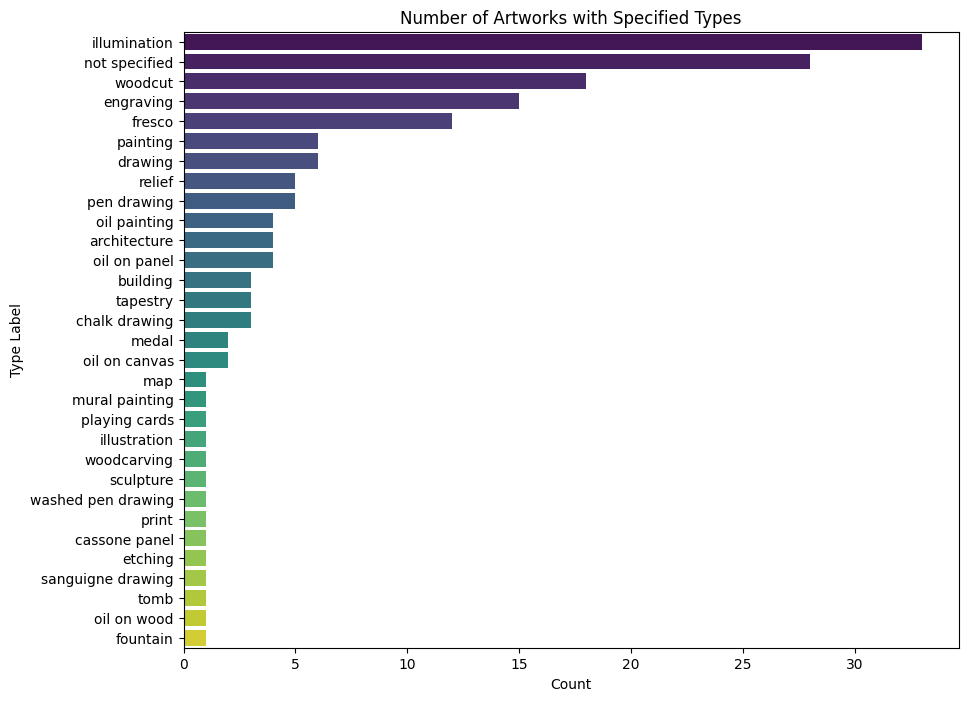

In [20]:
# Check if results exist
if results:
    # Create a dictionary to store the counts of each type
    type_counts = {}
    none_count = 0  # Counter for instances where typeLabel is None
    for row in results:
        type_label = row['typeLabel']
        if type_label is None:
            none_count += 1
        elif type_label not in type_counts:
            type_counts[type_label] = 1
        else:
            type_counts[type_label] += 1

    # Include the count of instances where typeLabel is None
    if none_count > 0:
        type_counts['not specified'] = none_count

    # Sort the type counts from the highest to the lowest
    sorted_type_counts = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract the labels and counts for plotting
    type_labels, type_values = zip(*sorted_type_counts)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.barplot(x=list(type_values), y=list(type_labels), hue=list(type_labels), palette='viridis', order=list(type_labels), dodge=False, legend=False)

    # Customize the plot
    plt.xlabel('Count')
    plt.ylabel('Type Label')
    plt.title('Number of Artworks with Specified Types')
    plt.show()
else:
    print("No results returned from the SPARQL query")


Let's examine **which artists are most represented within the time span from 1400 to 1600.**

In [21]:
# Define the SPARQL query
query = """
PREFIX d: <https://w3id.org/icon/data/>
PREFIX icon: <https://w3id.org/icon/ontology/>
PREFIX sim: <https://w3id.org/simulation/ontology/>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

SELECT ?artistLabel (COUNT(DISTINCT ?object) AS ?count)
WHERE {
    ?production crm:P108_has_produced ?object ;
                crm:P14_carried_out_by ?artist .

    ?object crm:P65_shows_visual_item ?artwork ; 
            crm:P102_has_title ?title ; 
            ^crm:P108_has_produced / crm:P4_has_time_span ?time . 

    ?time crm:P82a_begin_of_the_begin ?startDate .

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
            xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)

    ?artist a crm:E21_Person ;
            rdfs:label ?artistLabel .
}
GROUP BY ?artist ?artistLabel
ORDER BY DESC(?count)

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_artworks = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"The count of artists during the Renaissance period: {count_artworks}")
        else:
            print("There are no artists found within the Renaissance period.")

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Number of artists Renaissance period: 43
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artistLabel  43 non-null     object
 1   count        43 non-null     object
dtypes: object(2)
memory usage: 820.0+ bytes


,artistLabel,count
0,Michelangelo,16
1,Albrecht Dürer,14
2,Raphael,6
3,Piero di Cosimo,4
4,Andrea Mantegna,3
5,Sandro Botticelli,3
6,Agnolo Bronzino,3
7,Tiziano Vecellio,3
8,Donatello,2
9,Florentine Master,2


Since the dataset also accompanies artworks with evaluations of cultural phenomena by art historians, we thought it would be interesting to **search within those labels to identify instances where the term 'Renaissance' is mentioned and ascertain the artworks to which it refers.**

In [22]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX icon: <https://w3id.org/icon/ontology/>
    
    SELECT ?artwork ?culturalPhenomenon ?label ?intrinsicMeaning
    WHERE {
      ?artwork a icon:Artwork ;
               icon:iconologicallyRepresents ?culturalPhenomenon .
      ?culturalPhenomenon a icon:CulturalPhenomenon ;
                          rdfs:label ?label ;
                          icon:isCulturalPhenomenonOf ?intrinsicMeaning .
                          
      FILTER (REGEX(?label, "Renaissance", "i")) # "i" is case insensitive regex
    }
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_culturalPhenomenon = sum(1 for _ in results)
        
        if count_culturalPhenomenon > 0:
            print(f"The total count of cultural phenomena referencing the word \"Renaissance\": {count_culturalPhenomenon}")
        else:
            print("No cultural phenomena referencing the word \"Renaissance\"")

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

except Exception as e:
    print("An error occurred:", e)

df.info()
df

The total count of cultural phenomena referencing the word "Renaissance": 1129
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   artwork             1129 non-null   object
 1   culturalPhenomenon  1129 non-null   object
 2   label               1129 non-null   object
 3   intrinsicMeaning    1129 non-null   object
dtypes: object(4)
memory usage: 35.4+ KB


,artwork,culturalPhenomenon,label,intrinsicMeaning
0,https://w3id.org/icon/data/ART1432,https://w3id.org/icon/data/CF1044,Completing the existing structure with a gothi...,https://w3id.org/icon/data/ART1432-INTRINSIC1
1,https://w3id.org/icon/data/ART1433,https://w3id.org/icon/data/CF1052,Cover the gothic shapes with more contemporary...,https://w3id.org/icon/data/ART1433-INTRINSIC2
2,https://w3id.org/icon/data/ART1068,https://w3id.org/icon/data/CF1053,Crisis of the harmony conciliating the antique...,https://w3id.org/icon/data/ART1068-INTRINSIC1
3,https://w3id.org/icon/data/ART1200,https://w3id.org/icon/data/CF1069,"During Renaissance, Anteros is explicitly iden...",https://w3id.org/icon/data/ART1200-INTRINSIC1
4,https://w3id.org/icon/data/ART1151,https://w3id.org/icon/data/CF1094,Example of anticipation of Renaissance in the ...,https://w3id.org/icon/data/ART1151-INTRINSIC1
...,...,...,...,...
1124,https://w3id.org/icon/data/ART1104,https://w3id.org/icon/data/CF1240,Renascences of classical antiquity in Western ...,https://w3id.org/icon/data/ART1111-INTRINSIC1
1125,https://w3id.org/icon/data/ART1104,https://w3id.org/icon/data/CF1240,Renascences of classical antiquity in Western ...,https://w3id.org/icon/data/ART1113-INTRINSIC3
1126,https://w3id.org/icon/data/ART1104,https://w3id.org/icon/data/CF1240,Renascences of classical antiquity in Western ...,https://w3id.org/icon/data/ART1114-INTRINSIC3
1127,https://w3id.org/icon/data/ART1104,https://w3id.org/icon/data/CF1240,Renascences of classical antiquity in Western ...,https://w3id.org/icon/data/ART1151-INTRINSIC3


This data reveals that Cultural Phenomena are associated with more than one Intrinsic Meaning, and these connections are established between the artwork and the recognized intrinsic meaning through iconological recognition.

Let's do a step back to clarify how the dataset organized the data relative to the recognition of artworks.
From [the web site of the project](https://iconology-dataset.streamlit.app/) we read:

> **The interpretation act according to Panofsky**
> Although a methodology for artwork comprehension was considered by Warburg, the prevailing theoretical approach in the discipline consists of the subdivision of the artwork’s interpretation into 3 or 4 levels, a framework first defined by Erwin Panofsky.
According to him, there are different types of meaning that can be interpreted in an artwork subdivided in three layers. The depth to which the artwork can be understood depends on the background knowledge of the observer: the more he/she/they has knowledge about the artist, stylistic conventions, cultural context of him/her/them, the more the interpretation at each level is correct, including deeper insights on cultural meanings.
> 
> **Level 1 (Pre-iconographical description)**
> The first layer, namely the pre-iconographical description, requires the knowledge of the representational conventions to allow a correct recognition of factual (e.g. objects, people, actions) and emotional meanings, namely primary or natural subjects. In detail, this interpretation is achieved by the recognition of pure forms (i.e. combinations of forms and colours) as carriers of primary subjects. Pure forms such interpreted are called 'artistic motifs', and their combinations are 'compositions'. An enumeration of artistic motifs consistutes a pre-iconographical recognition of the artwork.
> 
> **Level 2 (Iconographical description)**
> If the observer is familiar with the literary sources known by the artist, then the subjects already identified at level 1, viz. the artistic motifs or compositions, can be recognised at the second level by the combination of them with concepts and themes, obtaining for example characters (e.g. Venus), personifications (e.g. Virtue), or events (e.g. the Battle of Cascina). The artistic motifs such recognized are called images or Invenzioni, namely the term used by ancient teorists to identify stories and allegories. Allegories are defined in opposition to stories as 'combinations of personifications and/or symbols', although there are many intermediate possibilities between them.
> 
> **Level 3 (Iconological analysis)**
> By knowing and understanding the cultural and societal aspects of the artist’s time, it is possible to read the artwork and the subjects identified at the previous levels as symptoms of the contemporary society, of the artist’s beliefs and personality or as the expression of meanings voluntarily inserted. The scholar highlights that the first two levels are a description of facts and are under the domain of iconography, whereas the last level is in the domain of iconology, which is a synthetic intuition and interpretation rather than a description.

We understand that the **Artistic Motif**, also known as the **Composition**, is associated with the initial recognition level, the **Pre-iconographical** phase. At this stage, it involves individual components of the subject displayed within a specific artwork under consideration. Conversely, the second level of recognition, **the Iconographical**,encompasses the entire image. To illustrate, while the Pre-iconographical level might identify elements such as wings, a bow, arrows, and a child, the iconographical recognition recognizes these components as representing Cupid. Moving further to the third level of recognition, **the Iconological** phase, we encounter the **Intrinsic Meaning**. Here, the **Composition**, **Image**, and **Artistic mMtif** (which has a **Factual Meaning**) form part of the intrinsic meaning, which can be identified within a **Cultural Phenomenon**.

This examination aimed to enhance our understanding of the intricate structure of the dataset we are working with. Furthermore, following the same line of inquiry, **we could explore the relationship between artistic motifs and their factual meanings, for instance. They can be of class "Natural Element", "Action", "Expressional Quality", and "Linguistic Object".**

In [23]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX cito: <http://purl.org/spar/cito/>
    
    SELECT DISTINCT ?artisticMotif ?typeLabel
    WHERE {
        VALUES ?rel {icon:hasCharacter icon:hasEvent icon:hasNamedObject icon:hasPlace icon:hasPersonification crm:P138_represents}
        ?iconograficalRecognition icon:recognizedImage ?image ;
                                  icon:aboutWorkOfArt ?artwork ;
                                  icon:refersToArtisticMotif ?composition .

        ?image ?rel ?lev2 .
        ?lev2 rdfs:label ?lev2Label .

        ?iconograficalRecognition2 icon:recognizedImage ?image2 ; 
                                   icon:aboutWorkOfArt ?artwork ;
                                   icon:refersToArtisticMotif ?am .
        ?image2 icon:hasSymbol ?simulation .
        ?composition icon:hasPart ?artisticMotif . 
        ?artisticMotif a icon:ArtisticMotif; 
                       icon:hasFactualMeaning | icon:hasExpressionalMeaning | crm:P138_represents ?lev1 .

        ?lev1 a ?type.
        ?type rdfs:label ?typeLabel.  

    FILTER(?image != ?image2)
    FILTER(?iconograficalRecognition != ?iconograficalRecognition2)        
    }
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df = pd.DataFrame(results)
        df = df.set_axis(['artistic_motif', 'type_label'], axis='columns')
        print(df.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

unique_values = df['type_label'].unique()
print(unique_values)

Before executing SPARQL query
After executing SPARQL query
                                artistic_motif            type_label
0  https://w3id.org/icon/data/ART1002test-AM10                Action
1  https://w3id.org/icon/data/ART1002test-AM23  Expressional Quality
2  https://w3id.org/icon/data/ART1003test-AM13       Natural Element
3  https://w3id.org/icon/data/ART1003test-AM18       Natural Element
4  https://w3id.org/icon/data/ART1003test-AM23       Natural Element
5   https://w3id.org/icon/data/ART1003test-AM3                Action
6   https://w3id.org/icon/data/ART1003test-AM8       Natural Element
7  https://w3id.org/icon/data/ART1009test-AM10       Natural Element
8   https://w3id.org/icon/data/ART1009test-AM4       Natural Element
9   https://w3id.org/icon/data/ART1013test-AM6                Action
[rdflib.term.Literal('Action') rdflib.term.Literal('Expressional Quality')
 rdflib.term.Literal('Natural Element')
 rdflib.term.Literal('Linguistic Object')]


Let's plot the result to see how many type of artistic motif are present in the dataset.

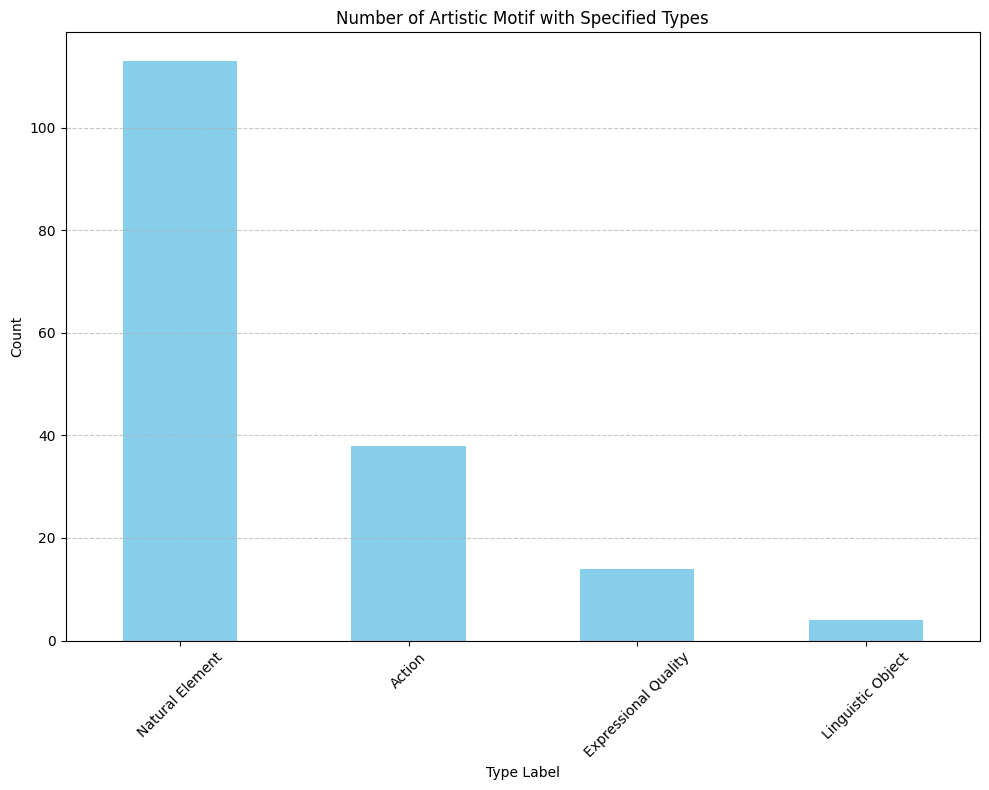

In [24]:
# Count the occurrences of each type_label
type_counts = df['type_label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 8))
type_counts.plot(kind='bar', color='skyblue')

# Add background grid
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines on the x-axis
    

plt.xlabel('Type Label')
plt.ylabel('Count')
plt.title('Number of Artistic Motif with Specified Types')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if needed
plt.tight_layout()
plt.show()

## 2.2. Filter Zeri Photo Archive Collection
Representing the model developed by the Zeri Foundation to describe the complexity of the photographic archive, alongside the collection of auction catalogs and archival materials, required the collaboration of various professionals. The interdisciplinary team behind the ***[Zeri & LODE project](https://data.fondazionezeri.unibo.it/)*** involves art historians from the Zeri Foundation, as well as experts in digital humanities and knowledge organization from the Department of Classical Philology and Italian Studies and the Department of Computer Science, Science, and Engineering at the University of Bologna.

As a best practice, the project chose to reuse existing and widely adopted ontologies in the Cultural Heritage domain, developing new models only for describing aspects that hadn’t been explored before. Ontologies like **[CIDOC-CRM](http://www.cidoc-crm.org/)**, used for describing art objects, and the **[SPAR Ontologies](http://www.sparontologies.net/)**, referencing the accompanying photographic and archival documentation, were accompanied by a specially designed model, HiCO, capable of representing the act of attribution. HiCO analyzes the methodologies employed by both the producing entity and the cataloger in selecting the attributed author for the works, whether they are sources, authoritative opinions, captions, or simple classifications of photos within the archive system.

This depth of knowledge representation also required a careful semiotic analysis of the "photograph" object, in its dual nature as a document and a monument: conveying the reproduced artwork but also reflecting the photographer's intent, thus itself becoming an artwork deserving of proper valorization.

The outcome of this conceptual analysis was the creation of two corresponding ontologies, the **[F Entry Ontology](http://www.essepuntato.it/2014/03/fentry)** and the **[OA Entry Ontology](http://purl.org/emmedi/oaentry)**, for respectively describing photographs and reproduced artworks. These ontologies aim to enhance this wealth of meta-information and ensure its proper reuse by researchers and other cultural institutions.

In accordance with these models, the RDF dataset was developed, representing around 30,000 F entries and 19,000 objects documented by the photographs. The data is available online ([Zeri Catalog](https://w3id.org/zericatalog/)) for free browsing through the RDF LODView browser, querying via SPARQL endpoint ([Fondazione Zeri SPARQL Endpoint](http://data.fondazionezeri.unibo.it/query)), and downloading ([AMS Acta](http://amsacta.unibo.it/5497/)).

Firstly, in the following code snippet, we perform a test query on the `zeri_graph` we parsed.

In [25]:
# Define the SPARQL query
query = """
    SELECT DISTINCT ?class_uri
    WHERE {
        ?anything a ?class_uri .
    } LIMIT 10
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
lists_classes = zeri_graph.query(query_obj)

# Uncomment the two following lines to see the list of classes
for row in lists_classes:
    print(row['class_uri'])

http://purl.org/emmedi/oaentry/OAEntry
http://www.cidoc-crm.org/cidoc-crm/E31_Document
http://www.cidoc-crm.org/cidoc-crm/E35_Title
http://www.cidoc-crm.org/cidoc-crm/E15_Identifier_Assignment
http://www.cidoc-crm.org/cidoc-crm/E42_Identifier
http://www.cidoc-crm.org/cidoc-crm/E55_Type
http://www.cidoc-crm.org/cidoc-crm/E40_Legal_Body
http://www.cidoc-crm.org/cidoc-crm/E65_Creation
http://www.cidoc-crm.org/cidoc-crm/E21_Person
http://purl.org/spar/fabio/MetadataDocument


Considering the usage of various namespaces within the Zeri's RDF dataset, we print them to enhance our comprehension.

In [26]:
# Get the namespace manager of the graph
namespace_manager = zeri_graph.namespace_manager

# Retrieve all prefixes used in the RDF graph
prefixes = {str(prefix): str(namespace_manager.store.namespace(prefix)) for prefix in namespace_manager.namespaces()}

# Display the prefixes and their corresponding URIs
for prefix, uri in prefixes.items():
    print(f"Prefix: {prefix}")

Prefix: ('brick', rdflib.term.URIRef('https://brickschema.org/schema/Brick#'))
Prefix: ('csvw', rdflib.term.URIRef('http://www.w3.org/ns/csvw#'))
Prefix: ('dc', rdflib.term.URIRef('http://purl.org/dc/elements/1.1/'))
Prefix: ('dcat', rdflib.term.URIRef('http://www.w3.org/ns/dcat#'))
Prefix: ('dcmitype', rdflib.term.URIRef('http://purl.org/dc/dcmitype/'))
Prefix: ('dcterms', rdflib.term.URIRef('http://purl.org/dc/terms/'))
Prefix: ('dcam', rdflib.term.URIRef('http://purl.org/dc/dcam/'))
Prefix: ('doap', rdflib.term.URIRef('http://usefulinc.com/ns/doap#'))
Prefix: ('foaf', rdflib.term.URIRef('http://xmlns.com/foaf/0.1/'))
Prefix: ('geo', rdflib.term.URIRef('http://www.opengis.net/ont/geosparql#'))
Prefix: ('odrl', rdflib.term.URIRef('http://www.w3.org/ns/odrl/2/'))
Prefix: ('org', rdflib.term.URIRef('http://www.w3.org/ns/org#'))
Prefix: ('prof', rdflib.term.URIRef('http://www.w3.org/ns/dx/prof/'))
Prefix: ('prov', rdflib.term.URIRef('http://www.w3.org/ns/prov#'))
Prefix: ('qb', rdflib.te

As an initial query, we count **how many artists are classified as painters in the dataset.**

In [27]:
# Define the SPARQL query
query = """
    PREFIX zeri1: <http://www.w3.org/ns/prov-o#>
    PREFIX pro: <http://purl.org/spar/pro/>
    PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?artist ?artistLabel
    WHERE {
        ?artist pro:withRole oaentry:painter ;
                rdfs:label ?artistLabel .
        FILTER(LANG(?artistLabel) = 'en')
    }
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

        print("Number of painters:", len(df))

    else:
        
        print("No painters founded")

except Exception as e:
    
    print("An error occurred:", e)

df.info()
df

Number of painters: 4465
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4465 entries, 0 to 4464
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist       4465 non-null   object
 1   artistLabel  4465 non-null   object
dtypes: object(2)
memory usage: 69.9+ KB


,artist,artistLabel
0,https://w3id.org/zericatalog/role/painter/bemb...,"Bembo Bonifacio, painter"
1,https://w3id.org/zericatalog/role/painter/pret...,"Preti Gregorio, painter"
2,https://w3id.org/zericatalog/role/painter/tucc...,"Tuccari Giovanni, painter"
3,https://w3id.org/zericatalog/role/painter/euse...,"Eusebio da San Giorgio, painter"
4,https://w3id.org/zericatalog/role/painter/giac...,"Giacomo da Riva, painter"
...,...,...
4460,https://w3id.org/zericatalog/role/painter/erri...,"Erri Bartolomeo degli, painter"
4461,https://w3id.org/zericatalog/role/painter/capr...,"Caprioli Domenico, painter"
4462,https://w3id.org/zericatalog/role/painter/pseu...,"Pseudo Scacco, painter"
4463,https://w3id.org/zericatalog/role/painter/stro...,"Stroifi Ermanno, painter"


Let's now see **how many titled artworks are presented in the catalog?**

In [28]:
# Define the SPARQL query
query_artwork = """
    PREFIX zeri1: <http://www.w3.org/ns/prov-o#>
    PREFIX pro: <http://purl.org/spar/pro/>
    PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX frbr: <http://purl.org/vocab/frbr/core#>
    PREFIX prov: <http://www.w3.org/ns/prov#>
    PREFIX fabio: <http://purl.org/spar/fabio/>

SELECT DISTINCT ?artwork ?artworkTitleLabel
WHERE { 
    ?photographs frbr:subject ?artwork ;
                 fabio:hasSubjectTerm ?photoSubject ;
                 crm:P102_has_title ?artworkTitle .
                 
    ?artworkTitle rdfs:label ?artworkTitleLabel .
    FILTER(LANG(?artworkTitleLabel) = 'en')
}

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query_artwork)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

        print("Number of artworks:", len(df))

    else:
        
        print("No artworks founded")

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Number of artworks: 25711
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25711 entries, 0 to 25710
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   artwork            25711 non-null  object
 1   artworkTitleLabel  25711 non-null  object
dtypes: object(2)
memory usage: 401.9+ KB


,artwork,artworkTitleLabel
0,https://w3id.org/zericatalog/artwork/42605/item,"Attributed title ""Negretti Iacopo - sec. XVI -..."
1,https://w3id.org/zericatalog/artwork/16567/item,"Proper title ""Roma. Cappella Sistina. Figura a..."
2,https://w3id.org/zericatalog/artwork/27111/item,"Attributed title ""Giovanni di Pietro - sec. XV..."
3,https://w3id.org/zericatalog/artwork/37625/item,"Attributed title ""Anonimo napoletano - sec. XV..."
4,https://w3id.org/zericatalog/artwork/41044/item,"Proper title ""A Portrait of a Gentleman wearin..."
...,...,...
25706,https://w3id.org/zericatalog/artwork/29553/item,"Proper title ""Spoleto - S. Maria delle Grazie ..."
25707,https://w3id.org/zericatalog/artwork/48045/item,"Proper title ""Lorenzo Lotto, Italian, Venetian..."
25708,https://w3id.org/zericatalog/artwork/27093/item,"Attributed title ""Giovanni di Pietro - sec. XV..."
25709,https://w3id.org/zericatalog/artwork/36898/item,"Attributed title ""Foschi Pier Francesco - sec...."


### Data Organization and Ontologies Used in the Zeri Photo Archive Collection

The Zeri Foundation cataloged Zeri's repository using two Italian metadata content standards: [Scheda F](http://www.iccd.beniculturali.it/index.php?it/473/standard-catalografici/Standard/10) (Scheda di fotografia) for photographs and [Scheda OA](http://www.iccd.beniculturali.it/index.php?it/473/standard-catalografici/Standard/29) (Scheda Opera d'Arte) for artworks. Will be used the original names Scheda F and Scheda OA and their English translations, F Entry and OA Entry, to refer to the metadata documents.

Both standards are part of the ICCD (Istituto Centrale per il Catalogo e la Documentazione), an institute under the Italian Ministry of Cultural Heritage overseeing cataloging standards for various cultural objects.

To complement the CIDOC-CRM model, the F Entry Ontology and the OA Entry Ontology were developed to address scenarios not covered by CIDOC-CRM.

The dataset begins with the photo as the catalog entry, potentially making the data structure appear complex initially. For a deeper understanding of the artwork-photo relationship, refer to the paper *"[Enhancing Semantic Expressivity in the Cultural Heritage Domain: Exposing the Zeri Photo Archive as Linked Open Data](https://essepuntato.it/papers/zeri-and-lode-jocch.html)."*

### Exploring Work-Expression-Manifestation-Item Relationship in FaBiO Ontology

- **oaentry:OAEntry**: A document containing metadata about an artwork and the object portrayed.
- **crm:E65_Creation**: Refers to the creation of the OA Entry document.
- **fabio:MetadataDocument**: Expresses the content of the OA Entry.
- **fabio:ArtisticWork**: Represents works of art using FRBR Work, Manifestation, and Item terms, considering aspects like essence, physical features, legal aspects, and location.
- **crm:E65_Creation**: Manifestation level describing the act of creation, including the creation's time span, artist/author details, and group attribution.
- **fabio:AnalogManifestation**: Item level describing material details (e.g., material composition).
- **fabio:AnalogItem**: Indicates the location of the Item.


In [29]:
# Define the SPARQL query
query = """
    PREFIX zeri1: <http://www.w3.org/ns/prov-o#>
    PREFIX pro: <http://purl.org/spar/pro/>
    PREFIX : <http://www.essepuntato.it/2014/03/fentry-abox/>
    PREFIX fentry: <http://www.essepuntato.it/2014/03/fentry/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX frbr: <http://purl.org/vocab/frbr/core#>
    PREFIX prov: <http://www.w3.org/ns/prov#>
    PREFIX fabio: <http://purl.org/spar/fabio/>
    PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
    PREFIX dc: <http://purl.org/dc/elements/1.1/>
    PREFIX emmedi: <http://purl.org/emmedi/>
    PREFIX hico: <http://purl.org/emmedi/hico/>
    PREFIX terms: <http://purl.org/dc/terms/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?oaEntry ?artisticArtwork ?manifestation ?analogItem
WHERE {

    ?oaEntry a oaentry:OAEntry .

    ?artisticArtwork a fabio:ArtisticWork;
                     fabio:hasManifestation ?manifestation.
    
    ?analogItem a fabio:AnalogItem .
    
    ?manifestation ?p ?analogItem .

} LIMIT 10

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:
        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results.bindings)


except Exception as e:
    print("An error occurred:", e)

df

,analogItem,artisticArtwork,manifestation,oaEntry
0,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/16885
1,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/35919
2,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/38690
3,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/45093
4,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/45646
5,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/36800
6,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/47269
7,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/41648
8,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/41946
9,https://w3id.org/zericatalog/artwork/18157/item,https://w3id.org/zericatalog/artwork/18157,https://w3id.org/zericatalog/artwork/18157/man...,https://w3id.org/zericatalog/oaentry/30693


This comprehension was essential for conducting complex queries that aim to determine **the number of artworks, within the selected timeframe, with specified type and location.**

In [30]:
# Define the SPARQL query
query = """
    PREFIX zeri1: <http://www.w3.org/ns/prov-o#>
    PREFIX pro: <http://purl.org/spar/pro/>
    PREFIX : <http://www.essepuntato.it/2014/03/fentry-abox/>
    PREFIX fentry: <http://www.essepuntato.it/2014/03/fentry/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX frbr: <http://purl.org/vocab/frbr/core#>
    PREFIX prov: <http://www.w3.org/ns/prov#>
    PREFIX fabio: <http://purl.org/spar/fabio/>
    PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
    PREFIX dc: <http://purl.org/dc/elements/1.1/>
    PREFIX emmedi: <http://purl.org/emmedi/>
    PREFIX hico: <http://purl.org/emmedi/hico/>
    PREFIX terms: <http://purl.org/dc/terms/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX psv: <http://www.wikidata.org/prop/statement/value/>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    PREFIX wds: <http://www.wikidata.org/entity/statement/>
    PREFIX wdv: <http://www.wikidata.org/value/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    PREFIX p: <http://www.wikidata.org/prop/>
    PREFIX ps: <http://www.wikidata.org/prop/statement/>
    PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT DISTINCT ?artwork ?artworkLabel ?artworkTypeLabel ?startDate ?keeperLabel ?locationLabel
WHERE {

    ?artwork a fabio:ArtisticWork  ;
             rdfs:label ?artworkLabel ;
             crm:P94i_was_created_by ?creation ;
             fabio:hasManifestation ?manifestation ;
             crm:P2_has_type ?artworkType .
                 
    ?artworkType rdfs:label ?artworkTypeLabel .
    FILTER(LANG(?artworkTypeLabel) = 'en')
                 
    ?creation crm:P4_has_time_span ?timeSpan .
    ?timeSpan ti:hasIntervalStartDate ?startDate .

    ?manifestation frbr:exemplar ?analogItem .

    ?analogItem crm:P50_has_current_keeper ?keeper .
    ?keeper rdfs:label ?keeperLabel .

    ?keeper crm:P74_has_current_or_former_residence ?location .
    ?location rdfs:label ?locationLabel .
    
    FILTER(
    xsd:dateTime(?startDate) >= xsd:dateTime("1400-01-01T00:00:00Z") &&
    xsd:dateTime(?startDate) <= xsd:dateTime("1600-12-31T23:59:59Z")
    )

}
ORDER BY ?startDate

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

        df = df.set_axis(['artwork','artworkLabel', 'artworkTypeLabel', 'startDate', 'keeperLabel', 'locationLabel'], axis='columns')
                
        # Modify the regex pattern to drop two capital letters at the end of 'locationLabel' with the last space
        df['locationLabel'] = df['locationLabel'].str.replace(r'\s+[A-Z]{2}$', '', regex=True)

except Exception as e:
    print("An error occurred:", e)

filtered_df = df.drop_duplicates(['artwork'])

# Reindex the DataFrame to create a continuous index sequence
filtered_df = filtered_df.reset_index(drop=True)

filtered_df.info()
filtered_df.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264318 entries, 0 to 264317
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   artwork           264318 non-null  object
 1   artworkLabel      264318 non-null  object
 2   artworkTypeLabel  264318 non-null  object
 3   startDate         264318 non-null  object
 4   keeperLabel       264318 non-null  object
 5   locationLabel     264318 non-null  object
dtypes: object(6)
memory usage: 12.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15944 entries, 0 to 15943
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artwork           15944 non-null  object
 1   artworkLabel      15944 non-null  object
 2   artworkTypeLabel  15944 non-null  object
 3   startDate         15944 non-null  object
 4   keeperLabel       15944 non-null  object
 5   locationLabel     15944 non-null  obje

,artwork,artworkLabel,artworkTypeLabel,startDate,keeperLabel,locationLabel
0,https://w3id.org/zericatalog/artwork/29205,"Artwork ""Anonimo umbro sec. XV , San Nicola di...",fresco,1400-01-01T00:00:00Z,Pinacoteca Comunale,Assisi
1,https://w3id.org/zericatalog/artwork/29470,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Francesco,Narni
2,https://w3id.org/zericatalog/artwork/29471,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Francesco,Narni
3,https://w3id.org/zericatalog/artwork/29473,"Artwork ""Anonimo umbro sec. XV , Santi"" , (fra...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Agostino,Narni
4,https://w3id.org/zericatalog/artwork/29472,"Artwork ""Anonimo umbro sec. XV , Cristo giudic...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Agostino,Narni
5,https://w3id.org/zericatalog/artwork/29489,"Artwork ""Anonimo umbro sec. XV , Santo"" , (fra...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Agostino,Narni
6,https://w3id.org/zericatalog/artwork/29461,"Artwork ""Anonimo umbro sec. XV , Persona a tre...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Francesco,Narni
7,https://w3id.org/zericatalog/artwork/29449,"Artwork ""Anonimo umbro sec. XV , San Giorgio e...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Francesco,Narni
8,https://w3id.org/zericatalog/artwork/29448,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400-01-01T00:00:00Z,Chiesa di S. Francesco,Narni
9,https://w3id.org/zericatalog/artwork/29451,"Artwork ""Anonimo umbro sec. XV , Testa d'uomo ...",mural drawing,1400-01-01T00:00:00Z,Chiesa di S. Francesco,Narni



The Zeri dataset also annotates the subjects depicted in the artworks. It doesn't adhere to a specific rule. However, if we compare it with the Iconology dataset regarding the level of iconography representation in the artworks, Zeri Archive utilizes the second level. This level recognizes and identifies iconographical objects such as women or men, labeled as "Maria vergine" or "Gesù Cristo," etc. The issue arises from the subjects being labeled in Italian and the lack of alignment between the classes in the two datasets.

Here's an example query that describes **the subjects recognized in an artwork, for instance, the *"Creation of Adam"* by Michelangelo.**

In [36]:
# Define the SPARQL query
query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX frbr: <http://purl.org/vocab/frbr/core#>
    PREFIX fabio: <http://purl.org/spar/fabio/>

    SELECT DISTINCT ?artworkLabel ?subjectLabel
    WHERE {
    
        <https://w3id.org/zericatalog/artwork/16568> a fabio:ArtisticWork  ;
                                                     rdfs:label ?artworkLabel ;
                                                     fabio:hasSubjectTerm ?subject.
        FILTER(LANG(?artworkLabel) = 'en')        
                 
        ?subject rdfs:label ?subjectLabel.
    
    }
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)


except Exception as e:
    print("An error occurred:", e)

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artworkLabel  1 non-null      object
 1   subjectLabel  1 non-null      object
dtypes: object(2)
memory usage: 148.0+ bytes


,artworkLabel,subjectLabel
0,"Artwork ""Buonarroti Michelangelo , Creazione d...",Creazione di Adamo


For our further analysis, it's crucial to consider this aspect, and we can explore it further by conducting some string-based searches.

# 3. Represent
After filtering and initial mining, data is represented or visualized in a meaningful way using graphs, charts, or statistical summaries. This step aims to present the insights gained from the data in a format that is easy to understand and interpret.

## 3.1. Represent Iconology Dataset

Let's now try to ask the more specific question about our time span.
**What are the most frequent subject represented at level 1 in Renaissance period?**

In [37]:
# Define the SPARQL query
query = """		
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT DISTINCT ?artisticMotif ?level1Label ?artwork ?startDate
    WHERE {
        ?production a crm:E12_Production ;
                    crm:P108_has_produced ?producedObject ;
                    crm:P4_has_time_span ?timeSpan .
        ?timeSpan crm:P82a_begin_of_the_begin ?startDate .
    
        BIND (xsd:integer(SUBSTR(?startDate, 1, 4)) AS ?startYear) .
      	FILTER (?startYear >= 1400 && ?startYear <= 1600)
      
        ?producedObject crm:P65_shows_visual_item ?artwork .
    
        ?preiconRecognition a icon:PreiconographicalRecognition ;
                            icon:aboutWorkOfArt ?artwork .
      
        ?preiconRecognition icon:recognizedArtisticMotif ?artisticMotif .
      
        ?artisticMotif icon:hasFactualMeaning | icon:hasExpressionalMeaning | crm:P138_represents ?level1 .
        ?level1 rdfs:label ?level1Label .
    }
    ORDER BY ?startDate
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df_level1 = pd.DataFrame(results)
        df_level1 = df_level1.set_axis(['artistic_motif', 'level1_label', 'artwork', 'start_date'], axis='columns')
        #print(df_level1.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df_level1  # Uncomment for a better reading of the table

Before executing SPARQL query
After executing SPARQL query


,artistic_motif,level1_label,artwork,start_date
0,https://w3id.org/icon/data/ART1331-AM1,woman,https://w3id.org/icon/data/ART1331,1400-01-01T00:00:00
1,https://w3id.org/icon/data/ART1331-AM2,woman,https://w3id.org/icon/data/ART1331,1400-01-01T00:00:00
2,https://w3id.org/icon/data/ART1331-AM3,sitting on,https://w3id.org/icon/data/ART1331,1400-01-01T00:00:00
3,https://w3id.org/icon/data/ART1331-AM4,fountain,https://w3id.org/icon/data/ART1331,1400-01-01T00:00:00
4,https://w3id.org/icon/data/ART1331-AM5,cross,https://w3id.org/icon/data/ART1331,1400-01-01T00:00:00
...,...,...,...,...
1082,https://w3id.org/icon/data/ART1308-AM2,wings,https://w3id.org/icon/data/ART1308,1584-01-01T00:00:00
1083,https://w3id.org/icon/data/ART1308-AM3,fighting,https://w3id.org/icon/data/ART1308,1584-01-01T00:00:00
1084,https://w3id.org/icon/data/ART1308-AM4,putto,https://w3id.org/icon/data/ART1308,1584-01-01T00:00:00
1085,https://w3id.org/icon/data/ART1308-AM5,wings,https://w3id.org/icon/data/ART1308,1584-01-01T00:00:00


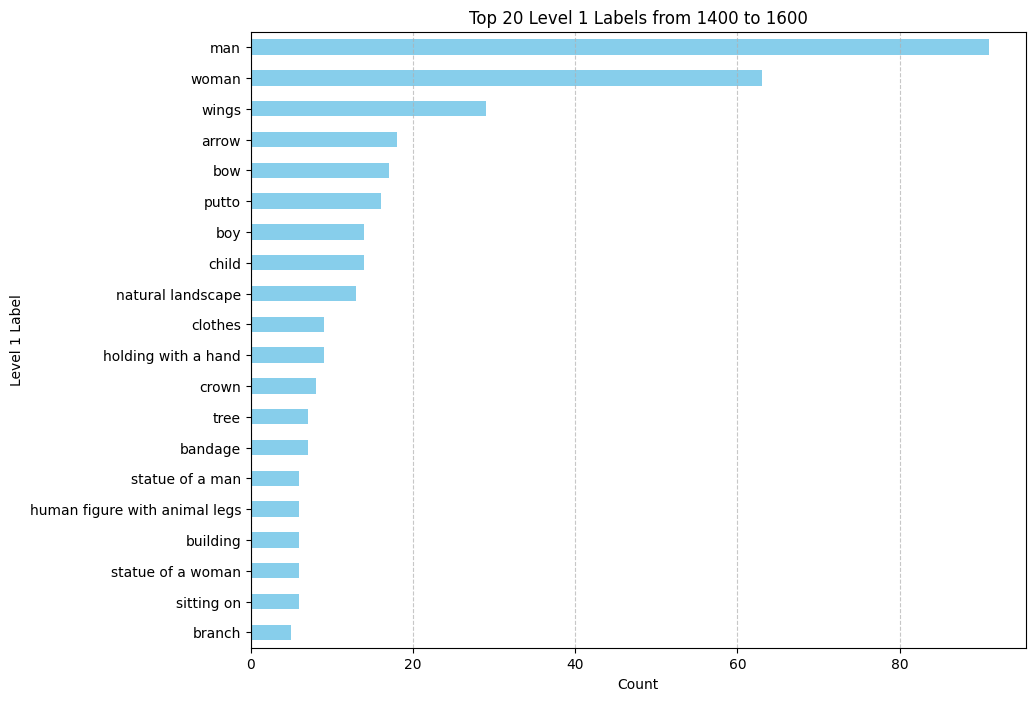

In [38]:
# Check if DataFrame exists and has data
if not df_level1.empty:
    # Get the top 20 value counts of 'level1_label'
    top_level1_labels = df_level1['level1_label'].value_counts().head(20)

    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    top_level1_labels.sort_values().plot(kind='barh', color='skyblue')

    # Add background grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines on the x-axis
    
    # Customize the plot
    plt.xlabel('Count')
    plt.ylabel('Level 1 Label')
    plt.title('Top 20 Level 1 Labels from 1400 to 1600')
    plt.show()
else:
    print("DataFrame is empty or doesn't exist.")


Before digging in the level two of Recognition, the Iconographical one, we need to introduce the concept of ***Invenzione**.
As the authors of the *ICON ontology* states in the paper [ICON: An Ontology for Comprehensive Artistic Interpretations](https://dl.acm.org/doi/10.1145/3594724):

The focus centers on Panofsky's second level of art interpretation, known as the iconographical interpretation. Within this level, interpreters recognize images and "invenzioni" within an artwork. An image represents a subject depicted in a specific artwork, linked to second-level subjects such as characters, places, events, named objects, symbols, and personifications, encapsulating iconographies from an abstract perspective. This distinction is crucial: the general subject level (e.g., characters, symbols) differs from the artwork-specific one (image). This differentiation aids in identifying subject variants concerning specific contexts; for instance, Thor depicted in a particular painting may differ from common portrayals.

An "invenzione" signifies the subject matter formed by combining general subjects linked to individual recognized images. Consider an artwork where three images are identified: the first symbolizes the general subject of Mary, the second symbolizes the general subject of Angel Gabriel, and the third symbolizes the general subject of the Holy Dove. The amalgamation of Mary, Angel Gabriel, and the Holy Dove constitutes the Annunciation—an "invenzione" in ontology terms. While the same "invenzione" could exist across multiple artworks, each artwork maintains uniqueness by possessing distinct images.

Subclasses like Story and Allegory are part of the Invenzione class. Stories are inclined towards characters, named objects, places, and events, whereas allegories focus more on symbols and personifications. Symbols can be expressed solely as symbolic meanings recognized or in more depth as Simulations.

The classes Image and Invenzione are connected to the class IconographicalRecognition through recognizedImage and recognizedInvenzione properties (one image or invenzione per recognition). Artistic motifs belonging to a pre-iconographical level are linked to an image through the property refersToArtisticMotif (e.g., an image representing Mary Magdalene linked to the artistic motif signifying woman). This linkage preserves the connection between pre-iconographical elements and respective iconographical subjects.

If an artistic motif primarily enables image recognition, it can be linked to that image using the hasRecAttribute property. Images are linked to the portrayed general subjects through specific properties based on the subject class (e.g., hasCharacter, hasEvent, hasPlace, hasNamedObject, hasSymbol, hasPersonification). The cited ICON classes encompass both real and fictional subjects (e.g., Medusa) in fictional representational spaces, in line with the modeling of subjects in narratology.

Finally, multiple iconographic recognitions contributing to an artwork's interpretation are linked to the interpretation through the iconographicallyCompliesWith property.

**Let's find out how many images are represented**

In [39]:
# Define the SPARQL query
query = """		
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT ?image ?level2Label ?artwork ?startDate
    WHERE {
        VALUES ?rel {icon:hasCharacter icon:hasEvent icon:hasNamedObject icon:hasPlace icon:hasPersonification icon:hasSymbol crm:P138_represents}
        ?production a crm:E12_Production ;
                    crm:P108_has_produced ?producedObject ;
                    crm:P4_has_time_span ?timeSpan .
        ?timeSpan crm:P82a_begin_of_the_begin ?startDate .
    
        # String transformation in order to perform the same query also on the online endpoint
        BIND (xsd:integer(SUBSTR(?startDate, 1, 4)) AS ?startYear) .
      	FILTER (?startYear >= 1400 && ?startYear <= 1600)
      
        ?producedObject crm:P65_shows_visual_item ?artwork .
    
        ?iconRecognition a icon:IconographicalRecognition ;
                         icon:aboutWorkOfArt ?artwork ;
                         icon:recognizedImage ?image .

        ?image a icon:Image ;
               ?rel ?level2 .
        ?level2 rdfs:label ?level2Label.
    }
    ORDER BY ?startDate
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
        
    # Check if results exist
    if results:
        df_level2_image = pd.DataFrame(results)
        df_level2_image = df_level2_image.set_axis(['image', 'level2_label', 'artwork', 'start_date'], axis='columns')
        #print(df_level2_image.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df_level2_image.info()
df_level2_image

Before executing SPARQL query
After executing SPARQL query
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         406 non-null    object
 1   level2_label  406 non-null    object
 2   artwork       406 non-null    object
 3   start_date    406 non-null    object
dtypes: object(4)
memory usage: 12.8+ KB


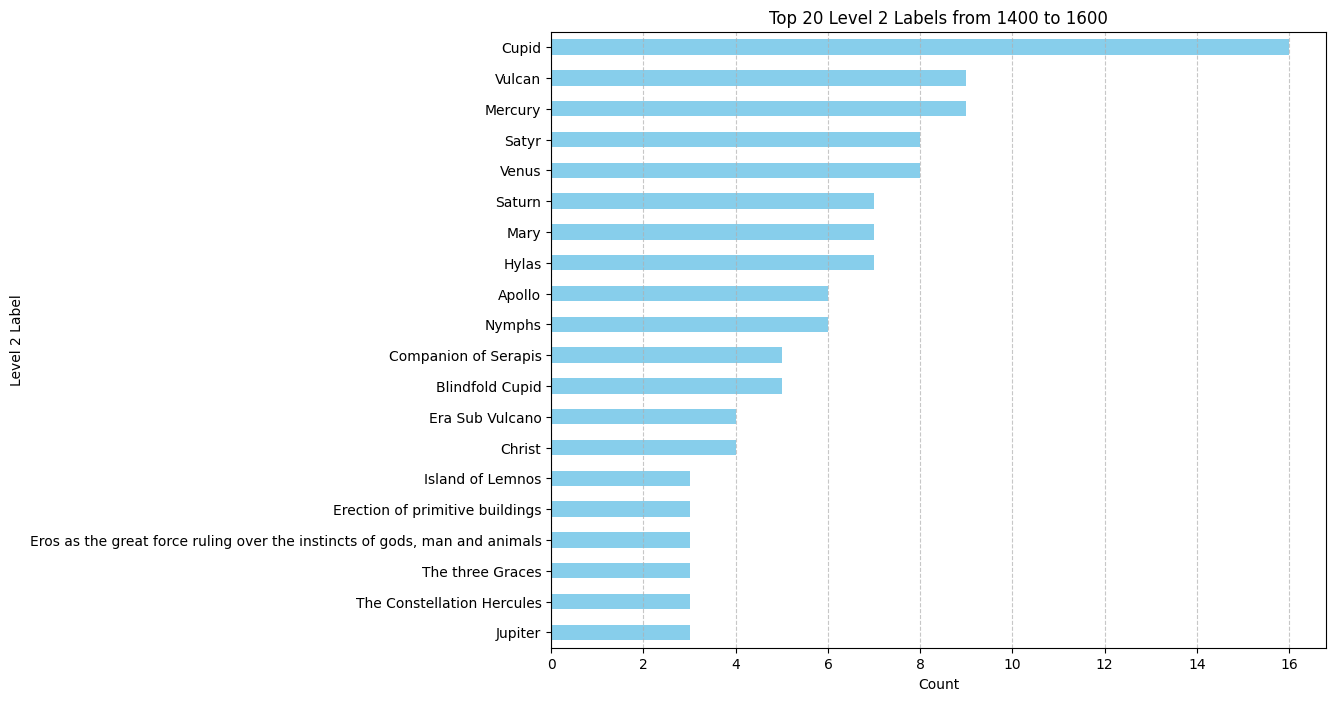

In [40]:
# Check if DataFrame exists and has data
if not df_level2_image.empty:
    # Get the top 20 value counts of 'level1_label'
    top_level2_image_labels = df_level2_image['level2_label'].value_counts().head(20)

    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    top_level2_image_labels.sort_values().plot(kind='barh', color='skyblue')

    # Add background grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines on the x-axis
    
    # Customize the plot
    plt.xlabel('Count')
    plt.ylabel('Level 2 Label')
    plt.title('Top 20 Level 2 Labels from 1400 to 1600')
    plt.show()
else:
    print("DataFrame is empty or doesn't exist.")


On this basis let's also see **how many different "invenzione" are in the timespan 1400-1600**.

In [41]:
# Define the SPARQL query
query = """		
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT ?invenzione ?invenzioneLabel ?artwork ?startDate
    WHERE {
        ?production a crm:E12_Production ;
                    crm:P108_has_produced ?producedObject ;
                    crm:P4_has_time_span ?timeSpan .
        ?timeSpan crm:P82a_begin_of_the_begin ?startDate .
    
        BIND (xsd:integer(SUBSTR(?startDate, 1, 4)) AS ?startYear) .
      	FILTER (?startYear >= 1400 && ?startYear <= 1600)
      
        ?producedObject crm:P65_shows_visual_item ?artwork .
    
        ?iconRecognition a icon:IconographicalRecognition ;
                         icon:aboutWorkOfArt ?artwork ;
                         icon:recognizedInvenzione ?invenzione .

        ?invenzione rdfs:label ?invenzioneLabel .         
    }
    ORDER BY ?startDate
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
        
    # Check if results exist
    if results:
        df_level2_invenzione = pd.DataFrame(results)
        df_level2_invenzione = df_level2_invenzione.set_axis(['invenzione', 'invenzioneLabel', 'artwork', 'start_date'], axis='columns')
        #print(df_level2_invenzione.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df_level2_invenzione.info()
df_level2_invenzione  # Uncomment for a better reading of the table

Before executing SPARQL query
After executing SPARQL query
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   invenzione       33 non-null     object
 1   invenzioneLabel  33 non-null     object
 2   artwork          33 non-null     object
 3   start_date       33 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


,invenzione,invenzioneLabel,artwork,start_date
0,https://w3id.org/icon/data/story/the-rape-of-p...,The rape of Proserpina,https://w3id.org/icon/data/ART1004test,1401-01-01T00:00:00
1,https://w3id.org/icon/data/story/immaculate-co...,Immaculate Conception,https://w3id.org/icon/data/ART1008test,1401-01-01T00:00:00
2,https://w3id.org/icon/data/story/the-annunciation,The Annunciation,https://w3id.org/icon/data/ART1008test,1401-01-01T00:00:00
3,https://w3id.org/icon/data/story/hermes-aglaur...,"Hermes, Aglauros and Herse",https://w3id.org/icon/data/ART1315,1401-01-01T00:00:00
4,https://w3id.org/icon/data/allegory/allegorica...,Allegorical explanation of the The three Grace...,https://w3id.org/icon/data/ART1044,1420-01-01T00:00:00
5,https://w3id.org/icon/data/story/the-annunciation,The Annunciation,https://w3id.org/icon/data/ART1009test,1434-01-01T00:00:00
6,https://w3id.org/icon/data/story/immaculate-co...,Immaculate Conception,https://w3id.org/icon/data/ART1009test,1434-01-01T00:00:00
7,https://w3id.org/icon/data/story/the-vision-of...,The vision of the Magi,https://w3id.org/icon/data/ART1232,1445-01-01T00:00:00
8,https://w3id.org/icon/data/story/abduction-of-...,Abduction of Helen,https://w3id.org/icon/data/ART1193,1460-01-01T00:00:00
9,https://w3id.org/icon/data/story/pygmalion-fal...,Pygmalion falls in love with the statue he is ...,https://w3id.org/icon/data/ART1120,1470-01-01T00:00:00


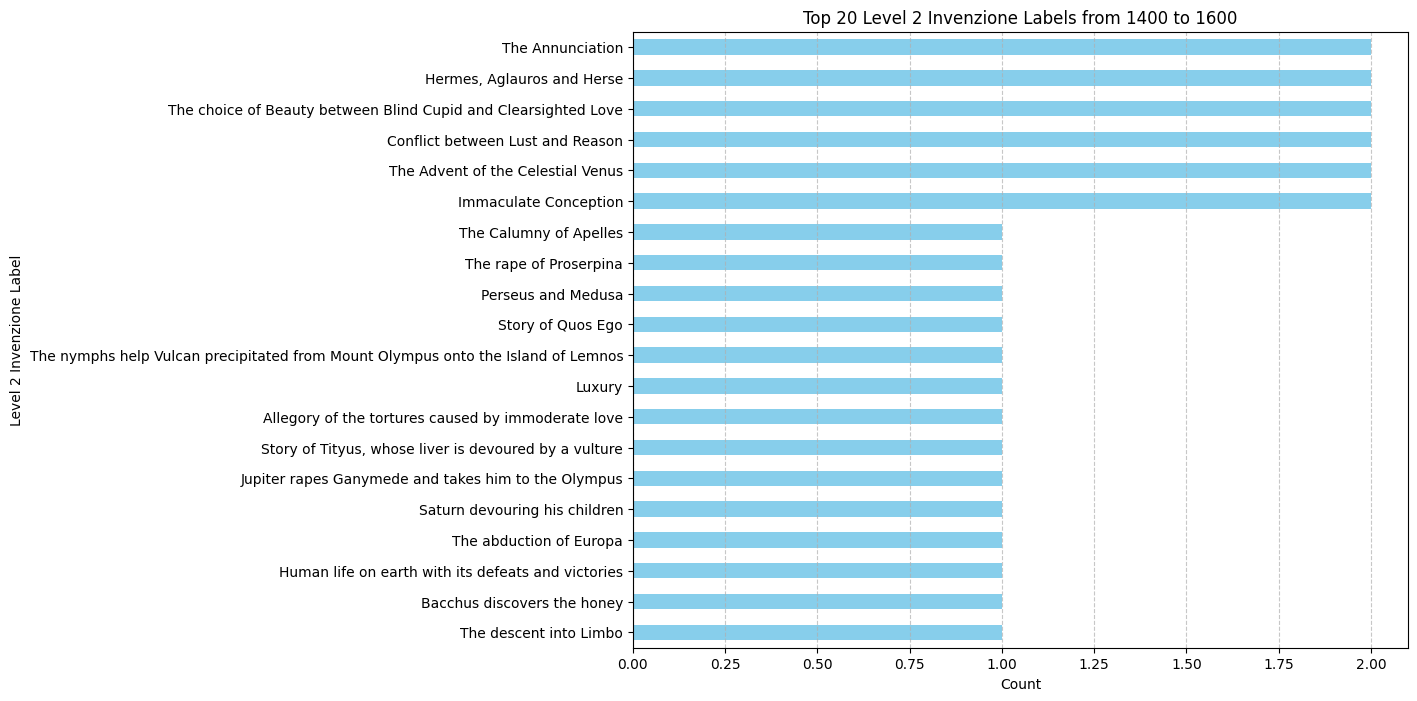

In [42]:
# Check if DataFrame exists and has data
if not df_level2_invenzione.empty:
    # Get the top 20 value counts of 'level1_label'
    top_level2_invenzione_labels = df_level2_invenzione['invenzioneLabel'].value_counts().head(20)

    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    top_level2_invenzione_labels.sort_values().plot(kind='barh', color='skyblue')

    # Add background grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines on the x-axis
    
    # Customize the plot
    plt.xlabel('Count')
    plt.ylabel('Level 2 Invenzione Label')
    plt.title('Top 20 Level 2 Invenzione Labels from 1400 to 1600')
    plt.show()
else:
    print("DataFrame is empty or doesn't exist.")


## 3.2. Represent Zeri Photo Archive Collection

Using the extensive artwork data from the Zeri Collection dataset merged with Wikidata's geolocation, we'll **plot the distribution of artworks on a map.**

In [4]:
# Define the SPARQL query
query = """
    PREFIX zeri1: <http://www.w3.org/ns/prov-o#>
    PREFIX pro: <http://purl.org/spar/pro/>
    PREFIX : <http://www.essepuntato.it/2014/03/fentry-abox/>
    PREFIX fentry: <http://www.essepuntato.it/2014/03/fentry/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX frbr: <http://purl.org/vocab/frbr/core#>
    PREFIX prov: <http://www.w3.org/ns/prov#>
    PREFIX fabio: <http://purl.org/spar/fabio/>
    PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
    PREFIX dc: <http://purl.org/dc/elements/1.1/>
    PREFIX emmedi: <http://purl.org/emmedi/>
    PREFIX hico: <http://purl.org/emmedi/hico/>
    PREFIX terms: <http://purl.org/dc/terms/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?artwork ?artworkLabel ?artworkTypeLabel (year(xsd:dateTime(?startDate)) AS ?year) ?keeperLabel ?locationLabel
WHERE {

    ?artwork a fabio:ArtisticWork  ;
             rdfs:label ?artworkLabel ;
             crm:P94i_was_created_by ?creation ;
             fabio:hasManifestation ?manifestation ;
             crm:P2_has_type ?artworkType .
                 
    ?artworkType rdfs:label ?artworkTypeLabel .
    FILTER(LANG(?artworkTypeLabel) = 'en')
                 
    ?creation crm:P4_has_time_span ?timeSpan .
    ?timeSpan ti:hasIntervalStartDate ?startDate .

    ?manifestation frbr:exemplar ?analogItem .

    ?analogItem crm:P50_has_current_keeper ?keeper .
    ?keeper rdfs:label ?keeperLabel .

    ?keeper crm:P74_has_current_or_former_residence ?location .
    ?location rdfs:label ?locationLabel .
    
    FILTER(
    xsd:dateTime(?startDate) >= xsd:dateTime("1400-01-01T00:00:00Z") &&
    xsd:dateTime(?startDate) <= xsd:dateTime("1600-12-31T23:59:59Z")
    )

}
ORDER BY ?startDate

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

        df = df.set_axis(['artwork','artworkLabel', 'artworkTypeLabel', 'year', 'keeperLabel', 'locationLabel'], axis='columns')
                
        # Modify the regex pattern to drop two capital letters at the end of 'locationLabel' with the last space
        df['locationLabel'] = df['locationLabel'].str.replace(r'\s+[A-Z]{2}$', '', regex=True)

except Exception as e:
    print("An error occurred:", e)

filtered_df = df.drop_duplicates(['artwork'])

# Reindex the DataFrame to create a continuous index sequence
filtered_df = filtered_df.reset_index(drop=True)

filtered_df.info()
filtered_df.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15944 entries, 0 to 15943
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artwork           15944 non-null  object
 1   artworkLabel      15944 non-null  object
 2   artworkTypeLabel  15944 non-null  object
 3   year              15944 non-null  object
 4   keeperLabel       15944 non-null  object
 5   locationLabel     15944 non-null  object
dtypes: object(6)
memory usage: 747.5+ KB


,artwork,artworkLabel,artworkTypeLabel,year,keeperLabel,locationLabel
0,https://w3id.org/zericatalog/artwork/29205,"Artwork ""Anonimo umbro sec. XV , San Nicola di...",fresco,1400,Pinacoteca Comunale,Assisi
1,https://w3id.org/zericatalog/artwork/29470,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400,Chiesa di S. Francesco,Narni
2,https://w3id.org/zericatalog/artwork/29471,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400,Chiesa di S. Francesco,Narni
3,https://w3id.org/zericatalog/artwork/29473,"Artwork ""Anonimo umbro sec. XV , Santi"" , (fra...",fresco,1400,Chiesa di S. Agostino,Narni
4,https://w3id.org/zericatalog/artwork/29472,"Artwork ""Anonimo umbro sec. XV , Cristo giudic...",fresco,1400,Chiesa di S. Agostino,Narni
5,https://w3id.org/zericatalog/artwork/29489,"Artwork ""Anonimo umbro sec. XV , Santo"" , (fra...",fresco,1400,Chiesa di S. Agostino,Narni
6,https://w3id.org/zericatalog/artwork/29461,"Artwork ""Anonimo umbro sec. XV , Persona a tre...",fresco,1400,Chiesa di S. Francesco,Narni
7,https://w3id.org/zericatalog/artwork/29449,"Artwork ""Anonimo umbro sec. XV , San Giorgio e...",fresco,1400,Chiesa di S. Francesco,Narni
8,https://w3id.org/zericatalog/artwork/29448,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400,Chiesa di S. Francesco,Narni
9,https://w3id.org/zericatalog/artwork/29451,"Artwork ""Anonimo umbro sec. XV , Testa d'uomo ...",mural drawing,1400,Chiesa di S. Francesco,Narni


In [5]:
#QUERY ALL THE ITALIAN MUNICIPALITIES AND THEIR COORDINATES FROM WIKIDATA

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

sparql.setQuery("""
    SELECT ?location ?locationLabel ?lat ?long 
    
    WHERE {
      ?location wdt:P31 wd:Q747074 ;
            p:P625 ?coords_stmt .
      ?coords_stmt ps:P625 ?coords ;
             psv:P625 [
               wikibase:geoLatitude ?lat ;
               wikibase:geoLongitude ?long ] .
         SERVICE wikibase:label {
         bd:serviceParam wikibase:language "it" .
       }
    }
""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Extracting the data into a DataFrame
data = []
for result in results['results']['bindings']:
    data.append({
        'location': result['location']['value'],
        'locationLabel': result['locationLabel']['value'],
        'lat': float(result['lat']['value']),
        'long': float(result['long']['value'])
    })

# Create DataFrame from the extracted data
wikidata_location_df = pd.DataFrame(data)

# Display the DataFrame
wikidata_location_df

,location,locationLabel,lat,long
0,http://www.wikidata.org/entity/Q10346,Vestignè,45.383333,7.950000
1,http://www.wikidata.org/entity/Q10221,Rivalba,45.118350,7.888125
2,http://www.wikidata.org/entity/Q10272,San Giusto Canavese,45.316667,7.816667
3,http://www.wikidata.org/entity/Q10265,San Gillio,45.142748,7.535817
4,http://www.wikidata.org/entity/Q10298,Scalenghe,44.892700,7.493611
...,...,...,...,...
7855,http://www.wikidata.org/entity/Q496951,Roccamena,37.835278,13.155556
7856,http://www.wikidata.org/entity/Q498938,Santa Teresa di Riva,37.940000,15.362500
7857,http://www.wikidata.org/entity/Q500485,Visone,44.662778,8.501667
7858,http://www.wikidata.org/entity/Q504554,Tubre,46.645612,10.464153


In [6]:
# Merge the two DataFrames based on the 'cityLabel' column
merged_df = pd.merge(filtered_df, wikidata_location_df, on='locationLabel', how='left')

# 'how='left'' ensures that all rows from filtered_df are retained
# 'on='locationLabel'' specifies the column to merge on

# Drop rows with NaN in the 'location' column since they are not in Italy
merged_df.dropna(subset=['location'], inplace=True)

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.info()

# Display the merged DataFrame
merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artwork           9504 non-null   object 
 1   artworkLabel      9504 non-null   object 
 2   artworkTypeLabel  9504 non-null   object 
 3   year              9504 non-null   object 
 4   keeperLabel       9504 non-null   object 
 5   locationLabel     9504 non-null   object 
 6   location          9504 non-null   object 
 7   lat               9504 non-null   float64
 8   long              9504 non-null   float64
dtypes: float64(2), object(7)
memory usage: 668.4+ KB


,artwork,artworkLabel,artworkTypeLabel,year,keeperLabel,locationLabel,location,lat,long
0,https://w3id.org/zericatalog/artwork/29205,"Artwork ""Anonimo umbro sec. XV , San Nicola di...",fresco,1400,Pinacoteca Comunale,Assisi,http://www.wikidata.org/entity/Q20103,43.070000,12.617500
1,https://w3id.org/zericatalog/artwork/29470,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400,Chiesa di S. Francesco,Narni,http://www.wikidata.org/entity/Q10866,42.516667,12.516667
2,https://w3id.org/zericatalog/artwork/29471,"Artwork ""Anonimo umbro sec. XV , Sant'Antonio ...",fresco,1400,Chiesa di S. Francesco,Narni,http://www.wikidata.org/entity/Q10866,42.516667,12.516667
3,https://w3id.org/zericatalog/artwork/29473,"Artwork ""Anonimo umbro sec. XV , Santi"" , (fra...",fresco,1400,Chiesa di S. Agostino,Narni,http://www.wikidata.org/entity/Q10866,42.516667,12.516667
4,https://w3id.org/zericatalog/artwork/29472,"Artwork ""Anonimo umbro sec. XV , Cristo giudic...",fresco,1400,Chiesa di S. Agostino,Narni,http://www.wikidata.org/entity/Q10866,42.516667,12.516667
...,...,...,...,...,...,...,...,...,...
9499,https://w3id.org/zericatalog/artwork/35625,"Artwork ""Tassi Agostino , Predica di san Giova...",painting,1600,"Palazzo Pitti, Galleria Palatina e Appartament...",Firenze,http://www.wikidata.org/entity/Q2044,43.771389,11.254167
9500,https://w3id.org/zericatalog/artwork/47270,"Artwork ""Anonimo lombardo sec. XVII , Gesù Bam...",painting,1600,Pinacoteca dell'Accademia Carrara,Bergamo,http://www.wikidata.org/entity/Q628,45.695000,9.670000
9501,https://w3id.org/zericatalog/artwork/44745,"Artwork ""Negretti Jacopo , Peccato originale""",painting,1600,Galleria Pallavicini,Roma,http://www.wikidata.org/entity/Q220,41.893056,12.482778
9502,https://w3id.org/zericatalog/artwork/44751,"Artwork ""Negretti Jacopo , Trasporto di Cristo...",painting,1600,Chiesa del Redentore,Venezia,http://www.wikidata.org/entity/Q641,45.439722,12.331944


In [15]:
# Creating the map
artwork_map = folium.Map(basemap=basemaps.CartoDB.Positron, location=[41.872, 12.567], zoom_start=5.5, scrollWheelZoom=False)

# Initialize marker cluster
marker_cluster = MarkerCluster().add_to(artwork_map)

for index, row in merged_df.iterrows():
    # Extract latitude and longitude from each row
    lat = row['lat']
    long = row['long']

    # Create marker location
    marker_location = (lat, long)

    # Create a marker and add it to the cluster
    folium.Marker(marker_location).add_to(marker_cluster)

# Display the map
display(artwork_map)

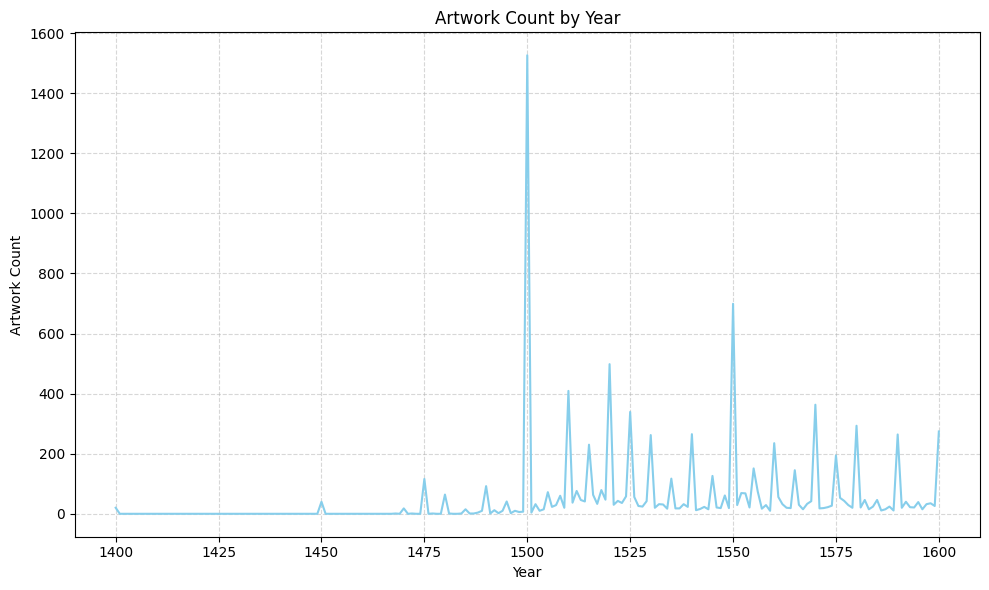

In [95]:
# Convert 'year' column in 'artwork_counts' DataFrame to int64
artwork_counts['year'] = artwork_counts['year'].astype('int64')

# Merge the 'all_years' DataFrame with 'artwork_counts' DataFrame
merged_df = pd.merge(all_years, artwork_counts, on='year', how='left')
merged_df['count'].fillna(0, inplace=True)

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(merged_df['year'], merged_df['count'], color='skyblue')

# Add background grid
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines on the y-axis
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add grid lines on the x-axis

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Artwork Count')
plt.title('Artwork Count by Year')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


Let's now examine **the subjects depicted in the artworks cataloged within the Zeri collection.**

In [100]:
# Define the SPARQL query
query = """
    PREFIX zeri1: <http://www.w3.org/ns/prov-o#>
    PREFIX pro: <http://purl.org/spar/pro/>
    PREFIX : <http://www.essepuntato.it/2014/03/fentry-abox/>
    PREFIX fentry: <http://www.essepuntato.it/2014/03/fentry/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX frbr: <http://purl.org/vocab/frbr/core#>
    PREFIX prov: <http://www.w3.org/ns/prov#>
    PREFIX fabio: <http://purl.org/spar/fabio/>
    PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
    PREFIX dc: <http://purl.org/dc/elements/1.1/>
    PREFIX emmedi: <http://purl.org/emmedi/>
    PREFIX hico: <http://purl.org/emmedi/hico/>
    PREFIX terms: <http://purl.org/dc/terms/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?artwork ?artworkLabel ?subjectLabel ?artworkTypeLabel (year(xsd:dateTime(?startDate)) AS ?year)
WHERE {

    ?artwork a fabio:ArtisticWork  ;
             rdfs:label ?artworkLabel ;
             crm:P94i_was_created_by ?creation ;
             fabio:hasSubjectTerm ?subject ;
             crm:P2_has_type ?artworkType .
                 
    ?artworkType rdfs:label ?artworkTypeLabel .
    FILTER(LANG(?artworkTypeLabel) = 'en')

    ?subject rdfs:label ?subjectLabel .
                 
    ?creation crm:P4_has_time_span ?timeSpan .
    ?timeSpan ti:hasIntervalStartDate ?startDate .

    
    FILTER(
    xsd:dateTime(?startDate) >= xsd:dateTime("1400-01-01T00:00:00Z") &&
    xsd:dateTime(?startDate) <= xsd:dateTime("1600-12-31T23:59:59Z")
    )

}
ORDER BY ?startDate

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = zeri_graph.query(query_obj)

    if results:

        # Convert SPARQL results to a pandas DataFrame
        subject_df = pd.DataFrame(results, columns=results.vars)

        subject_df = df.set_axis(['artwork','artworkLabel', 'subjectLabel', 'artworkTypeLabel', 'year'], axis='columns')

except Exception as e:
    print("An error occurred:", e)

subject_df = subject_df.drop_duplicates(['artwork'])

# Reindex the DataFrame to create a continuous index sequence
subject_df = subject_df.reset_index(drop=True)

subject_df.info()
subject_df.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18528 entries, 0 to 18527
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artwork           18528 non-null  object
 1   artworkLabel      18528 non-null  object
 2   subjectLabel      18528 non-null  object
 3   artworkTypeLabel  18528 non-null  object
 4   year              18528 non-null  object
dtypes: object(5)
memory usage: 723.9+ KB


,artwork,artworkLabel,subjectLabel,artworkTypeLabel,year
0,https://w3id.org/zericatalog/artwork/29205,San Nicola di Bari,san Nicola di Bari,fresco,1400
1,https://w3id.org/zericatalog/artwork/29470,Sant'Antonio Abate,Sant'Antonio Abate,fresco,1400
2,https://w3id.org/zericatalog/artwork/29471,Sant'Antonio Abate,Sant'Antonio Abate,fresco,1400
3,https://w3id.org/zericatalog/artwork/29473,(fragment),Santi,fresco,1400
4,https://w3id.org/zericatalog/artwork/29472,(fragment),Cristo giudice in trono e angeli tra sant'Andrea,fresco,1400
5,https://w3id.org/zericatalog/artwork/29489,(fragment),Santo,fresco,1400
6,https://w3id.org/zericatalog/artwork/29461,Persona a tre teste come simbolo della Trinità...,Persona a tre teste come simbolo della Trinità...,fresco,1400
7,https://w3id.org/zericatalog/artwork/29449,San Giorgio e il drago,San Giorgio e il drago,fresco,1400
8,https://w3id.org/zericatalog/artwork/29448,Sant'Antonio Abate,Sant'Antonio Abate,fresco,1400
9,https://w3id.org/zericatalog/artwork/29451,(fragment),Testa d'uomo e testa di cavallo,mural drawing,1400


In [104]:
# Count occurrences of 'Cristo' and 'Cupido' in the 'artworkLabel' column
count_cristo = subject_df['subjectLabel'].str.contains('Cristo', case=False).sum()
count_cupido = subject_df['subjectLabel'].str.contains('Cupido', case=False).sum()
count_madonna = subject_df['subjectLabel'].str.contains('Madonna', case=False).sum()
count_madonna_con_bambino = subject_df['subjectLabel'].str.contains('Madonna con Bambino', case=False).sum()
count_venere = subject_df['subjectLabel'].str.contains('Venere', case=False).sum()
count_vulcano = subject_df['subjectLabel'].str.contains('Vulcano', case=False).sum()

print(f"Occurrences of 'Cristo': {count_cristo}")
print(f"Occurrences of 'Cupido': {count_cupido}")
print(f"Occurrences of 'Madonna': {count_madonna}")
print(f"Occurrences of 'Madonna con Bambino': {count_madonna_con_bambino}")
print(f"Occurrences of 'Venere': {count_venere}")
print(f"Occurrences of 'Vulcano': {count_vulcano}")

Occurrences of 'Cristo': 1669
Occurrences of 'Cupido': 93
Occurrences of 'Madonna': 3342
Occurrences of 'Madonna con Bambino': 2886
Occurrences of 'Venere': 194
Occurrences of 'Vulcano': 16


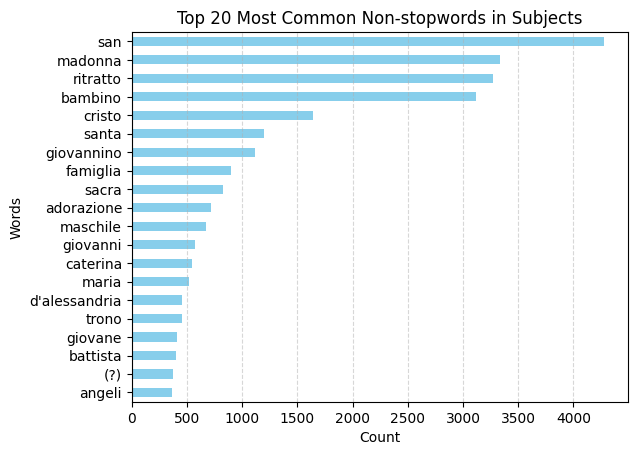

In [111]:
# Setting the stop-words
stop_words = set(stopwords.words('italian'))

# Tokenize the text and count occurrences after removing stop words
word_counts = subject_df['subjectLabel'].str.lower().str.split().explode()
word_counts = word_counts[~word_counts.isin(stop_words)].value_counts()

# Plot the top 20 most common words
top_words = word_counts.head(20)
top_words[::-1].plot(kind='barh', color='skyblue')

plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add grid lines on the x-axis

plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 20 Most Common Non-stopwords in Subjects')
plt.show()

Let's try to look to **the former or current location of the arteork between 1400 and 1600**

In [16]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT DISTINCT ?artwork ?title ?locationLabel ?geoRegion ?startDate
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork ; 
                crm:P102_has_title ?title ; 
                ^crm:P108_has_produced / crm:P4_has_time_span ?time ;
                crm:P53_has_former_or_current_location ?location .

        ?location rdfs:label ?locationLabel ;
                  crm:P89_falls_within ?geoRegion .

        ?time crm:P82a_begin_of_the_begin ?startDate ; 
              crm:P82b_end_of_the_end ?endDate .

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
                xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)
    }
    ORDER BY ?startDate
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_artworks = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"Number of artworks within the period 1400-16000 with place specified: {count_artworks}")
        else:
            print("No artwork within the period 1400-16000 with place specified")

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Number of artworks within the Italian Renaissance period: 107
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artwork        107 non-null    object
 1   title          107 non-null    object
 2   locationLabel  107 non-null    object
 3   geoRegion      107 non-null    object
 4   startDate      107 non-null    object
dtypes: object(5)
memory usage: 4.3+ KB


,artwork,title,locationLabel,geoRegion,startDate
0,https://w3id.org/icon/data/ART1202ext,https://w3id.org/icon/data/title/the-medal-of-...,"Kunsthistorisches Museum, Vienna",http://vocab.getty.edu/tgn/1000062,1400-01-01T00:00:00
1,https://w3id.org/icon/data/ART1202ext,https://w3id.org/icon/data/title/the-medal-of-...,"Kunsthistorisches Museum, Vienna",http://vocab.getty.edu/tgn/7003321,1400-01-01T00:00:00
2,https://w3id.org/icon/data/ART1331,https://w3id.org/icon/data/title/nature-and-grace,"Kunsthistorisches Museum, Vienna",http://vocab.getty.edu/tgn/1000062,1400-01-01T00:00:00
3,https://w3id.org/icon/data/ART1331,https://w3id.org/icon/data/title/nature-and-grace,"Kunsthistorisches Museum, Vienna",http://vocab.getty.edu/tgn/7003321,1400-01-01T00:00:00
4,https://w3id.org/icon/data/ART1184,https://w3id.org/icon/data/title/annunciation-...,"Musée Jacquemart-André, Paris",http://vocab.getty.edu/tgn/1000070,1410-01-01T00:00:00
...,...,...,...,...,...
102,https://w3id.org/icon/data/ART1220,https://w3id.org/icon/data/title/summer,"Kunsthistorisches Museum, Vienna",http://vocab.getty.edu/tgn/1000062,1563-01-01T00:00:00
103,https://w3id.org/icon/data/ART1220,https://w3id.org/icon/data/title/summer,"Kunsthistorisches Museum, Vienna",http://vocab.getty.edu/tgn/7003321,1563-01-01T00:00:00
104,https://w3id.org/icon/data/ART1380,https://w3id.org/icon/data/title/tityus,"Prado, Madrid",http://vocab.getty.edu/tgn/1000095,1565-01-01T00:00:00
105,https://w3id.org/icon/data/ART1380,https://w3id.org/icon/data/title/tityus,"Prado, Madrid",http://vocab.getty.edu/tgn/7010413,1565-01-01T00:00:00


Let's now count the place that got the highest number of renaissance artworks.

In [19]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    
    SELECT DISTINCT ?geoRegion (COUNT(?geoRegion) AS ?regionCount)
    WHERE {
        ?object crm:P65_shows_visual_item ?artwork ; 
                crm:P102_has_title ?title ; 
                ^crm:P108_has_produced / crm:P4_has_time_span ?time ;
                crm:P53_has_former_or_current_location ?location .

        ?location rdfs:label ?locationLabel ;
                  crm:P89_falls_within ?geoRegion .

        ?time crm:P82a_begin_of_the_begin ?startDate ; 
              crm:P82b_end_of_the_end ?endDate .

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
                xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)
    }
    GROUP BY ?geoRegion
    ORDER BY DESC(?regionCount)
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_places = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"Number of distinct places where artworks within the 1400-1600 period are kept: {count_places}")
        else:
            print("No distinct place where artworks are kept within the 1400-1600 period is specified")

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Number of distinct places where artworks within the 1400-1600 period are kept: 29
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   geoRegion    29 non-null     object
 1   regionCount  29 non-null     object
dtypes: object(2)
memory usage: 596.0+ bytes


,geoRegion,regionCount
0,http://vocab.getty.edu/tgn/1000080,14
1,http://vocab.getty.edu/tgn/7003669,12
2,http://vocab.getty.edu/tgn/7012149,10
3,http://vocab.getty.edu/tgn/7000457,8
4,http://vocab.getty.edu/tgn/7008591,6
5,http://vocab.getty.edu/tgn/7011781,6
6,http://vocab.getty.edu/tgn/7003712,6
7,http://vocab.getty.edu/tgn/7001168,5
8,http://vocab.getty.edu/tgn/1000062,5
9,http://vocab.getty.edu/tgn/7003321,5


Let's see if is it possible to retrieve, from the Getty endpoint the label of the geographical region.

In [30]:


# Define the SPARQL query
query = """
PREFIX d: <https://w3id.org/icon/data/> 
PREFIX icon: <https://w3id.org/icon/ontology/> 
PREFIX sim: <https://w3id.org/simulation/ontology/>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT DISTINCT ?geoRegion (COUNT(?geoRegion) AS ?regionCount) ?label
WHERE {
    ?object crm:P65_shows_visual_item ?artwork ; 
            crm:P102_has_title ?title ; 
            ^crm:P108_has_produced / crm:P4_has_time_span ?time ;
            crm:P53_has_former_or_current_location ?location .

    ?location rdfs:label ?locationLabel ;
              crm:P89_falls_within ?geoRegion .

    # Fetching labels for Getty Vocabulary IDs
    SERVICE <http://vocab.getty.edu/sparql> {
        ?geoRegion skos:prefLabel ?label .
        FILTER(LANG(?label) = 'en')
    }

    ?time crm:P82a_begin_of_the_begin ?startDate .

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
            xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)
}
GROUP BY ?geoRegion ?label
ORDER BY DESC(?regionCount)

"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_places = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"Number of distinct places where artworks within the 1400-1600 period are kept: {count_places}")
        else:
            print("No distinct place where artworks are kept within the 1400-1600 period is specified")

        # Convert SPARQL results to a pandas DataFrame
        df = pd.DataFrame(results, columns=results.vars)

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Number of distinct places where artworks within the 1400-1600 period are kept: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   geoRegion    25 non-null     object
 1   regionCount  25 non-null     object
 2   label        25 non-null     object
dtypes: object(3)
memory usage: 732.0+ bytes


,geoRegion,regionCount,label
0,http://vocab.getty.edu/tgn/1000080,14,Italy
1,http://vocab.getty.edu/tgn/7003669,12,Bavaria
2,http://vocab.getty.edu/tgn/7012149,10,United States
3,http://vocab.getty.edu/tgn/7000457,8,Florence
4,http://vocab.getty.edu/tgn/7008591,6,United Kingdom
5,http://vocab.getty.edu/tgn/7011781,6,London
6,http://vocab.getty.edu/tgn/7003712,6,Berlin
7,http://vocab.getty.edu/tgn/7001168,5,Holy See
8,http://vocab.getty.edu/tgn/1000062,5,Austria
9,http://vocab.getty.edu/tgn/7003321,5,Vienna


Let's try to filter the different places in Italy. Is to be said that for architectonical artworks we don't have the musuem but the city.

In [8]:
# Define the SPARQL query
query = """
PREFIX d: <https://w3id.org/icon/data/>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?artwork ?title ?museumLabel
WHERE {
    ?object crm:P65_shows_visual_item ?artwork ;
        crm:P102_has_title ?title ;
        ^crm:P108_has_produced / crm:P4_has_time_span ?time ;
        crm:P53_has_former_or_current_location ?location .

    ?location rdfs:label ?locationLabel ;
              crm:P89_falls_within ?geoRegion .

    ?time crm:P82a_begin_of_the_begin ?startDate .

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
            xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)

    # Filter for artworks in Italy
    FILTER EXISTS {
        ?location crm:P89_falls_within <http://vocab.getty.edu/tgn/1000080> .
    }
 	
  	?museum a crm:E53_Place ;
            rdfs:label ?museumLabel .

    # Retrieve museums/places where artworks are located in Italy
    ?object crm:P53_has_former_or_current_location ?museum .
    ?museum crm:P89_falls_within <http://vocab.getty.edu/tgn/1000080> .

}
ORDER BY ?artwork
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_artworks = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"Number of distinct places in Itlay where artworks within the 1400-1600 period are kept: {count_artworks}")
        else:
            print("No distinct place where artworks are kept, in Italy, within the 1400-1600 period is specified")

        # Convert SPARQL results to a pandas DataFrame and process the title URIs
        df = pd.DataFrame(results, columns=results.vars)

        df = df.set_axis(['artwork', 'title', 'museumLabel'], axis='columns')
        
        # Extract the last part after the final '/' character in the 'title' column
        df['title'] = df['title'].map(lambda x: x.split('/')[-1])

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Number of distinct places in Itlay where artworks within the 1400-1600 period are kept: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artwork      14 non-null     object
 1   title        14 non-null     object
 2   museumLabel  14 non-null     object
dtypes: object(3)
memory usage: 468.0+ bytes


,artwork,title,museumLabel
0,https://w3id.org/icon/data/ART1068,the-descent-into-limbo,"Museum of Santa Croce, Florence"
1,https://w3id.org/icon/data/ART1072,s-andrea,Mantua
2,https://w3id.org/icon/data/ART1188,atys-amorinohere-interpreted-as-time-as-a-play...,"Bargello, Florence"
3,https://w3id.org/icon/data/ART1194,hercules-fighting-the-hydra,"Uffizi, Florence"
4,https://w3id.org/icon/data/ART1198,bust-of-a-young-man,"Bargello, Florence"
5,https://w3id.org/icon/data/ART1202,the-birth-of-venus,"Uffizi, Florence"
6,https://w3id.org/icon/data/ART1203,the-realm-of-venus-_la-primavera_,"Uffizi, Florence"
7,https://w3id.org/icon/data/ART1204,the-calumny-of-apelles,"Uffizi, Florence"
8,https://w3id.org/icon/data/ART1243ext,villa-farnesina,Rome
9,https://w3id.org/icon/data/ART1246ext,pazzi-chapel,Florence


SINCE ALL THe stuff we have seen we can try to exand the research to the most represented artis:Michelangelo.

In [4]:
# Define the SPARQL query
query = """
PREFIX d: <https://w3id.org/icon/data/>
PREFIX icon: <https://w3id.org/icon/ontology/>
PREFIX sim: <https://w3id.org/simulation/ontology/>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

SELECT ?artwork ?title ?typeLabel ?locationLabel ?motivatorLabel ?startDate
WHERE {
    ?production crm:P108_has_produced ?object ;
                crm:P14_carried_out_by <https://w3id.org/icon/data/person/michelangelo> .
  
    OPTIONAL {
        ?production crm:P17_was_motivated_by ?motivator .
        ?motivator rdfs:label ?motivatorLabel .
    }

    ?object crm:P65_shows_visual_item ?artwork ; 
            crm:P102_has_title ?title ; 
            ^crm:P108_has_produced / crm:P4_has_time_span ?time .

            ?time crm:P82a_begin_of_the_begin ?startDate .

    FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
            xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)
  
    OPTIONAL {
        ?object crm:P2_has_type ?type .
        ?type rdfs:label ?typeLabel .
    }
  
  
    OPTIONAL {
      	?object  crm:P53_has_former_or_current_location ?location .
       ?location rdfs:label ?locationLabel .
    }
}
ORDER BY ?startDate
"""

try:
    # Prepare the SPARQL query
    query_obj = prepareQuery(query)
    
    # Execute the query and retrieve the results
    results = iconology_graph.query(query_obj)
    
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_artworks = sum(1 for _ in results)
        
        if count_artworks > 0:
            print(f"Artwork by Michelangelo: {count_artworks}")
        else:
            print("No artworks by Michelangelo")

        # Convert SPARQL results to a pandas DataFrame and process the title URIs
        df = pd.DataFrame(results, columns=results.vars)

        df = df.set_axis(['title', 'typeLabel', 'locationLabel', 'motivatorLabel', 'startDate'], axis='columns')
        
        # Extract the last part after the final '/' character in the 'title' column
        df['title'] = df['title'].map(lambda x: x.split('/')[-1])

except Exception as e:
    print("An error occurred:", e)

df.info()
df

Artwork by Michelangelo: 16
An error occurred: Length mismatch: Expected axis has 6 elements, new values have 5 elements
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   artwork         16 non-null     object
 1   title           16 non-null     object
 2   typeLabel       13 non-null     object
 3   locationLabel   9 non-null      object
 4   motivatorLabel  3 non-null      object
 5   startDate       16 non-null     object
dtypes: object(6)
memory usage: 900.0+ bytes


,artwork,title,typeLabel,locationLabel,motivatorLabel,startDate
0,https://w3id.org/icon/data/ART1533,https://w3id.org/icon/data/title/battle-of-cen...,relief,None,None,1490-01-01T00:00:00
1,https://w3id.org/icon/data/ART1521,https://w3id.org/icon/data/title/david,sculpture,"Galleria dell'Accademia, Florence",None,1501-01-01T00:00:00
2,https://w3id.org/icon/data/ART1346,https://w3id.org/icon/data/title/sitting-man-n...,pen drawing,"British Museum, London",None,1504-01-01T00:00:00
3,https://w3id.org/icon/data/ART1206ext,https://w3id.org/icon/data/title/first-project...,None,None,None,1505-01-01T00:00:00
4,https://w3id.org/icon/data/ART1352,https://w3id.org/icon/data/title/side-elevation,drawing,None,None,1505-01-01T00:00:00
5,https://w3id.org/icon/data/ART1216ext,https://w3id.org/icon/data/title/vault-frescoe...,fresco,"Sistine Chapel, Vatican City",None,1508-01-01T00:00:00
6,https://w3id.org/icon/data/ART1530,https://w3id.org/icon/data/title/the-creation-...,fresco,"Sistine Chapel, Vatican City",None,1511-01-01T00:00:00
7,https://w3id.org/icon/data/ART1251ext,https://w3id.org/icon/data/title/front-elevati...,None,None,None,1513-01-01T00:00:00
8,https://w3id.org/icon/data/ART1252ext,https://w3id.org/icon/data/title/side-elevatio...,None,None,None,1513-01-01T00:00:00
9,https://w3id.org/icon/data/ART1355,https://w3id.org/icon/data/title/second-projec...,drawing,None,None,1513-01-01T00:00:00


EXAMPLE OF STRUCTURE

d:ART1000 a icon:Artwork ;
    icon:hasRecogniton d:ART1000-ICONOLREC1,
        d:ART1000-ICREC1,
        d:ART1000-ICREC2,
        d:ART1000-PREICREC1,
        d:ART1000-PREICREC2,
        d:ART1000-PREICREC3,
        d:ART1000-PREICREC4,
        d:ART1000-PREICREC5,
        d:ART1000-PREICREC6 ;
    icon:iconographicallyDepicts d:jupiter,
        d:venus ;
    icon:iconologicallyRepresents d:CF1040 ;
    icon:preiconographicallyDepicts d:dove,
        d:eagle,
        d:man,
        d:woman .

d:ART1000-AM1 a icon:ArtisticMotif ;
    dul:hasQuality <https://w3id.org/icon/data/quality/nudity> ;
    icon:hasFactualMeaning d:woman ;
    icon:isRecognizedArtisticMotifOf d:ART1000-PREICREC1 .

d:ART1000-PREICREC1 a icon:PreiconographicalRecognition ;
    cito:citesForInformation <https://doi.org/10.2307/1522803> ;
    crm:P14_carried_out_by <https://w3id.org/icon/data/person/sofia-baroncini> ;
    icon:aboutWorkOfArt d:ART1000 ;
    icon:preiconographicallyCompliesWith d:ART1000-DESC ;
    icon:recognizedArtisticMotif d:ART1000-AM1 

d:woman a icon:NaturalElement ;
    rdfs:label "woman" ;
    owl:sameAs <https://iconclass.org/31A72> ;
    icon:isFactualMeaningOf d:ART1000-AM1,
        d:ART1001test-AM1,
        d:ART1002test-AM1,
        d:ART1004test-AM13, ecc.

d:OBJ1000 a crm:E25_Human_Made_Feature ;
    rdfs:label "Raphael, Venus imploring Jupiter, 1518, Rome, Villa Farnesina" ;
    crm:P102_has_title <https://w3id.org/icon/data/title/venus-imploring-jupiter> ;
    crm:P2_has_type <http://vocab.getty.edu/aat/300177433> ;
    crm:P53_has_former_or_current_location <https://w3id.org/icon/data/place/rome-villa-farnesina> ;
    crm:P56i_is_found_on d:OBJ1151ext-vault ;
    crm:P65_shows_visual_item d:ART1000 ;
    crm:P67_refers_to <https://doi.org/10.2307/1522803> ;
    foaf1:depiction <https://commons.wikimedia.org/wiki/File:Raffael,_Loggia_di_Psiche,_Villa_Farnesina,_Rome_11.jpg> .

In [5]:
# Define the SPARQL query
query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX d: <https://w3id.org/icon/data/>

SELECT DISTINCT ?producedObject ?objectTitle ?period ?author ?motivator ?startDate 
WHERE {
  ?production a crm:E12_Production ;
              crm:P108_has_produced ?producedObject ;
              crm:P4_has_time_span ?timeSpan .
  ?timeSpan crm:P82a_begin_of_the_begin ?startDate .
  BIND (xsd:integer(SUBSTR(?startDate, 1, 4)) AS ?startYear) .
  ?producedObject crm:P102_has_title ?objectTitle .
  
  OPTIONAL { ?production crm:P10_falls_within ?period }
  OPTIONAL { ?production crm:P14_carried_out_by ?author }
  OPTIONAL { ?production crm:P17_was_motivated_by ?motivator }

  # Filter for start year after 1400
  FILTER (?startYear >= 1400 && ?startYear <= 1600)
}
ORDER BY ?startDate
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df1 = pd.DataFrame(results)
        df1 = df1.set_axis(['produced_object', 'object_title', 'period', 'author', 'motivator', 'start_date'], axis='columns')
        print(df1.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df1  # Uncomment for a better reading of the table
df1.info()

Before executing SPARQL query
After executing SPARQL query
                          produced_object  \
0      https://w3id.org/icon/data/OBJ1117   
1      https://w3id.org/icon/data/OBJ1118   
2      https://w3id.org/icon/data/OBJ1173   
3   https://w3id.org/icon/data/OBJ1191ext   
4   https://w3id.org/icon/data/OBJ1202ext   
5      https://w3id.org/icon/data/OBJ1331   
6  https://w3id.org/icon/data/OBJ1004test   
7      https://w3id.org/icon/data/OBJ1007   
8  https://w3id.org/icon/data/OBJ1008test   
9      https://w3id.org/icon/data/OBJ1015   

                                 period author motivator           start_date  \
0                                  None   None      None  1400-01-01T00:00:00   
1                                  None   None      None  1400-01-01T00:00:00   
2                                  None   None      None  1400-01-01T00:00:00   
3                                  None   None      None  1400-01-01T00:00:00   
4                                  None 

In [22]:
# Define the SPARQL query
query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX d: <https://w3id.org/icon/data/>

SELECT ?period ?periodLabel
WHERE {
  ?period a crm:E4_Period .
  OPTIONAL { ?period rdfs:label ?periodLabel }
}
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df2 = pd.DataFrame(results)
        df2 = df2.set_axis(['period', 'period_label'], axis='columns')
        print(df2.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df2  # Uncomment for a better reading of the table

Before executing SPARQL query
After executing SPARQL query
                                              period  \
0               http://vocab.getty.edu/aat/300022045   
1  https://w3id.org/icon/data/period/florentine-m...   
2  https://w3id.org/icon/data/period/venetian-hig...   
3               http://vocab.getty.edu/aat/300021144   
4  https://w3id.org/icon/data/period/florentine-r...   
5  https://w3id.org/icon/data/period/manfredian-o...   
6               http://vocab.getty.edu/aat/300020072   
7               http://vocab.getty.edu/aat/300020072   
8               http://vocab.getty.edu/aat/300020666   
9               http://vocab.getty.edu/aat/300020666   

                                period_label  
0                        Counter-Reformation  
1                       Florentine Mannerism  
2                  Venetian High Renaissance  
3                                  Mannerism  
4                     Florentine Renaissance  
5            Manfredian or Federician peri

,period,period_label
0,http://vocab.getty.edu/aat/300022045,Counter-Reformation
1,https://w3id.org/icon/data/period/florentine-m...,Florentine Mannerism
2,https://w3id.org/icon/data/period/venetian-hig...,Venetian High Renaissance
3,http://vocab.getty.edu/aat/300021144,Mannerism
4,https://w3id.org/icon/data/period/florentine-r...,Florentine Renaissance
5,https://w3id.org/icon/data/period/manfredian-o...,Manfredian or Federician period
6,http://vocab.getty.edu/aat/300020072,Ancient Greece
7,http://vocab.getty.edu/aat/300020072,Ancient Greek
8,http://vocab.getty.edu/aat/300020666,Late Antique Roman Style (IV - V Century)
9,http://vocab.getty.edu/aat/300020666,Late Roman Antiquity


In [25]:
# Merge both DataFrames on the 'period' column
merged_df = pd.merge(df1, df2, on='period', how='left')

df1.info()


# Explode the lists in the 'period_label' column into separate rows
exploded_df = df1.explode('period_label')

# Get unique values from the exploded 'period_label' column
unique_values = exploded_df['period_label'].dropna().unique()
print(unique_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   produced_object  168 non-null    object
 1   period           9 non-null      object
 2   author           93 non-null     object
 3   motivator        9 non-null      object
 4   start_date       168 non-null    object
 5   object_title     168 non-null    object
 6   period_label     9 non-null      object
dtypes: object(7)
memory usage: 9.3+ KB
[rdflib.term.Literal('Renaissance') rdflib.term.Literal('Medieval')
 rdflib.term.Literal('Middle Ages')
 rdflib.term.Literal('Florentine Renaissance')
 rdflib.term.Literal('Venetian High Renaissance')
 rdflib.term.Literal('Florentine Mannerism')
 rdflib.term.Literal('Mannerism')]


# References

## ICON
https://dl.acm.org/doi/10.1145/3594724
https://ceur-ws.org/Vol-3540/paper4.pdf

## Zeri dataset
https://essepuntato.it/papers/zeri-and-lode-jocch.html


